# load packages

In [1]:
import os
import matplotlib.pyplot as plt
from skimage import io, color
import numpy as np
from skimage import util
from skimage.morphology import binary_dilation, disk, remove_small_objects, skeletonize,binary_opening, remove_small_holes, binary_erosion
from scipy import ndimage as ndi
from scipy.spatial.distance import cdist
from scipy.ndimage import binary_hit_or_miss
from skimage.measure import regionprops
from skimage.graph import route_through_array
import pandas as pd
import math
from skimage.transform import resize
import sys
from skimage.draw import line
from skimage.filters import threshold_otsu, threshold_mean
import pickle

# define functions

In [2]:
def cutout_plant_from_original(img, binary_final_img):
    mask = binary_final_img > 0

    r = img[:, :, 0] * mask
    g = img[:, :, 1] * mask
    b = img[:, :, 2] * mask

    img_temp = np.dstack([r, g, b])

    return img_temp

In [3]:
def find_branches(skel):
    """Detect branching points of a skeleton"""
    # Five possible matrix representation
    struct1 = np.array([[0, 1, 0], [0, 1, 0], [1, 0, 1]])
    struct2 = np.array([[1, 0, 0], [0, 1, 1], [0, 1, 0]])
    struct3 = np.array([[1, 0, 0], [0, 1, 0], [1, 0, 1]])
    struct4 = np.array([[0, 0, 0], [1, 1, 1], [0, 1, 0]])
    struct5 = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]])

    # Match branching point structures with the skeleton
    structs = [np.rot90(struct1, i)
               for i in range(4)]
    structs += [np.rot90(struct2, i) for i in range(4)]
    structs += [np.rot90(struct3, i) for i in range(4)]
    structs += [np.rot90(struct4, i) for i in range(4)]
    structs += [np.rot90(struct5, i) for i in range(4)]

    ret = None
    for i in range(len(structs)):
        if ret is None:
            ret = binary_hit_or_miss(skel, structure1=structs[i])
        else:
            ret = np.logical_xor(
                ret, binary_hit_or_miss(skel, structure1=structs[i]))
    return np.transpose(np.nonzero(ret))

In [4]:
def find_end_points(skel):
    """Detect end points of a skeleton"""
    # Four possible matrix representation
    struct1, origin1 = np.array([
        [0, 0, 0],
        [0, 1, 0],
    ]), (0, 0)
    struct2, origin2 = np.array([
        [0, 0],
        [0, 1],
        [0, 0],
    ]), (0, 0)
    struct3, origin3 = np.array([
        [0, 1, 0],
        [0, 0, 0],
    ]), (-1, 0)
    struct4, origin4 = np.array([
        [0, 0],
        [1, 0],
        [0, 0],
    ]), (0, -1)

    struct_except = np.array([[0, 0, 1], [0, 1, 0], [0, 0, 1]])
    struct_excepts = [np.rot90(struct_except, i) for i in range(4)]

    # Match end point structures with the skeleton
    ret = None
    for i in range(1, 5):
        struct, origin = locals()['struct%d' %
                                  (i)], locals()['origin%d' %
                                                 (i)] 
        if ret is None:
            ret = binary_hit_or_miss(skel, structure1=struct,
                                     origin1=origin)  
        else:
            ret = np.logical_or(
                ret, binary_hit_or_miss(skel,
                                        structure1=struct,
                                        origin1=origin))

    ret_temp = None
    for i in range(len(struct_excepts)):
        if ret_temp is None:
            ret_temp = binary_hit_or_miss(skel, structure1=struct_excepts[i])
        else:
            ret_temp = np.logical_xor(
                ret_temp, binary_hit_or_miss(skel,
                                             structure1=struct_excepts[i]))

    ret = np.logical_and(ret, np.logical_not(ret_temp))
    return np.transpose(np.nonzero(ret))

In [5]:
def get_rgb_color(seed_mask, seed_img):

    r, g, b = seed_img[:,:,0], seed_img[:,:,1], seed_img[:,:,2]
    r_mean = np.sum(seed_mask * r) / np.sum(seed_mask)
    g_mean = np.sum(seed_mask * g) / np.sum(seed_mask)
    b_mean = np.sum(seed_mask * b) / np.sum(seed_mask)

    return r_mean, g_mean, b_mean

In [6]:
def get_ske(seed_mask, show_result=False):
    ske = skeletonize(seed_mask)
    ske_temp = ske.copy()
    store_list = []
    branch_points = find_branches(ske)
    for point in branch_points:
        temp = ske[point[0] - 1:point[0] + 2,
                        point[1] - 1:point[1] + 2].copy()
        store_list.append(temp)
        ske_temp[point[0] - 1:point[0] + 2, point[1] - 1:point[1] + 2] = 0

    end_points = find_end_points(ske)

    struct = [[1, 1, 1], [1, 1, 1], [1, 1, 1]]
    ske_label, _ = ndi.label(ske_temp, structure=struct)
    ske_regions = regionprops(ske_label)
    for region in ske_regions:
        flag = 1
        for end_point in end_points:
            if flag:
                if region.area < 5 and np.any(
                    (region.coords == end_point).all(axis=1) == 1):
                    ske_temp[region.coords[:, 0], region.coords[:, 1]] = 0
                    flag = 0

    for point_index, point in enumerate(branch_points):
        ske_temp[point[0] - 1:point[0] + 2,
                 point[1] - 1:point[1] + 2] = store_list[point_index]

    new_end_points = find_end_points(ske_temp)
    for [end_i, end_j] in new_end_points:
        flag = 1
        for [branch_i, branch_j] in branch_points:
            if flag:
                if (branch_i - end_i)**2 + (branch_j - end_j)**2 < 4:
                    ske_temp[end_i, end_j] = 0
                    flag = 0

    if (show_result):
        fig, ax = plt.subplots(2, 1, figsize=(20, 20))
        ax[0].imshow(ske)
        ax[1].imshow(ske_temp)
        plt.show()
        plt.close()

    return ske_temp

In [110]:
class class_seed:
    def __init__(self):
        self.seed_flag = 0  # check whether the seed is in imbibition stage or germination stage
        self.overlap_flag = 0
        self.seed_coords = ''
        ## germination traits
#         self.root_length_dict = {}
        self.root_growth_rate_dict = {}
        self.root_num = 0
        self.root_endpoint_dict = {}
        self.root_startpoint_dict = {}
        self.root_flag_dict = {}
        self.root_update_flag_dict = {}
        self.reconstruction_ske = {}
        ## imbibition traits
        self.length_list = []
        self.width_list = []
        self.area_list = []
        self.perimeter_list = []
        self.roundness_list = []
        self.wl_ratio = []
        self.color_dict = {
            'R':[],
            'G':[],
            'B':[],
        }
        ## green related
        self.seedling_trans = ''
        self.seedling_emergence = ''
        self.seedling_len = []
        
        self.cls = []
        self.yolo_box = ''
        
    def reset_root_update_flag(self, value=0):
        for tmp_key in self.root_update_flag_dict:
            self.root_update_flag_dict[tmp_key] = value

    def update_seed_flag(self, value=0):
        self.seed_flag = value

    def update_seed_coords(self, seedcoat_coords):
        self.seed_coords = seedcoat_coords

    def update_root_endpoint(self, num, endpoint):
        self.root_endpoint_dict[num] = endpoint

    def update_root_startpoint(self, num, startpoint):
        self.root_startpoint_dict[num] = startpoint

    def update_seed_centroid(self, seed_centroid):
        self.seed_centroid = seed_centroid

    def store_seedpheno(self, length, width, area, perimeter, roundness,wl_ratio, color_list):
        self.length_list.append(length)
        self.width_list.append(width)
        self.area_list.append(area)
        self.perimeter_list.append(perimeter)
        self.roundness_list.append(roundness)
        self.wl_ratio.append(wl_ratio)
        self.color_dict['R'].append(color_list[0])
        self.color_dict['G'].append(color_list[1])
        self.color_dict['B'].append(color_list[2])

    def update_root_length(self, num, length, img_index=''):
        if img_index == '':  # 根长数据更新
#             self.root_length_dict[num].append(length)
            self.root_growth_rate_dict[num].append(length)
        else:
#             self.root_length_dict[num] = [0] * img_index
            self.root_growth_rate_dict[num] = [0] * img_index
#             self.root_length_dict[num].append(length)
            self.root_growth_rate_dict[num].append(length)

    def store_reconstruction_ske(self, num, tmp_rr, tmp_cc, img_index=''):
        if img_index == '':  # 根长数据更新
            self.reconstruction_ske[num]['rr'].append(tmp_rr)
            self.reconstruction_ske[num]['cc'].append(tmp_cc)
        else:
            self.reconstruction_ske[num] = {'rr': [], 'cc': []}
            self.reconstruction_ske[num]['rr'].extend([[''] for _ in range(img_index)])
            self.reconstruction_ske[num]['cc'].extend([[''] for _ in range(img_index)])
            self.reconstruction_ske[num]['rr'].append(tmp_rr)
            self.reconstruction_ske[num]['cc'].append(tmp_cc)

In [8]:
def compute_vec_angle(x1, x2):
    num1 = x1[0] * x2[0] + x1[1] * x2[1]
    num2 = pow(x1[0]**2 + x1[1]**2, 0.5)
    num3 = pow(x2[0]**2 + x2[1]**2, 0.5)

    return num1 / (num2 * num3)

def get_min_distance(points1,points2):
    min_distance=10000
    index1 = -1
    index2 = -1
    for i in range(len(points1)):
        for j in range(len(points2)):
            distance=pow(((points1[i][0]-points2[j][0])**2+(points1[i][1]-points2[j][1])**2),0.5)
            if(distance<min_distance):
                min_distance=distance
                index1=i
                index2=j
    return min_distance,index1,index2

def remove_d_dist_points(crossovers, d):
    min_dist = 1
    while (0 <= min_dist < d):
        if len(crossovers) == 1:
            break
        min_dist = -1
        index1 = -1
        index2 = -1
        for i in range(len(crossovers) - 1):
            for j in range(i + 1, len(crossovers)):
                x_diff = abs(crossovers[i][0] - crossovers[j][0])
                y_diff = abs(crossovers[i][1] - crossovers[j][1])
                if x_diff < d and y_diff < d:
                    min_dist = min(x_diff, y_diff)
                    index1 = i
                    inxex2 = j
                    break
            if min_dist >= 0:
                crossovers = np.delete(crossovers, index1, axis=0)
                break

    return np.array(crossovers)

# initialization

In [9]:
input_dir = './example_G7/'
out_dir = './traits/traits/'
mask_overall_dir = './model_predict/G7_overall/'
mask_seed_dir = './model_predict/G7_seed/'
mask_seedling_dir = './model_predict/G7_seedling/'
yolo_pickle_dir = './model_predict/G7_phase/'
row_num = 5
col_num = 5

In [10]:
color_dict = {1: 'ro', 2: 'wo', 3: 'go', 4: 'co', 5: 'yo', 6: 'mo', 7: 'ro', }

# trait extraction

In [111]:
files = sorted(os.listdir(input_dir))
seed_class_list = []
previous_mask = ''
seed_num = 0
fig_out_dir = os.path.join(out_dir, 'root_mask')
fig_out_dir2 = os.path.join(out_dir, 'root_mask2')
if not os.path.exists(fig_out_dir):
    os.makedirs(fig_out_dir)
    os.makedirs(fig_out_dir2)

struct = [[1, 1, 1],
          [1, 1, 1],
          [1, 1, 1]]
d = 20

last_file_name = files[-1]
image_origion = io.imread(os.path.join(input_dir, last_file_name))
image_origion = util.img_as_ubyte(
    resize(image_origion, (image_origion.shape[0] / 2, image_origion.shape[1] / 2), anti_aliasing=True))
last_file_prefix = last_file_name.split('.')[0]
seedling_mask = io.imread(os.path.join(mask_seedling_dir, f'{last_file_prefix}.png')) > 0
seedling_mask = util.img_as_ubyte(
    resize(seedling_mask, (image_origion.shape[0], image_origion.shape[1]), anti_aliasing=False))
exg = 2 * image_origion[:,:,1] - image_origion[:,:,0] -image_origion[:,:,2]
chloroplast_biogenesis_thre = threshold_mean(exg[seedling_mask>0])


for file_index, file_name in enumerate(files):
    print('*' * 40 + file_name + '*' * 40)
    file_prefix = file_name.split('.')[0]
    tmp_f = open(os.path.join(yolo_pickle_dir, f'{file_prefix}.pkl'), 'rb')
    tmp_yolo_box = pickle.load(tmp_f)
    tmp_yolo_box = [box for box in tmp_yolo_box if box.conf >= 0.5]
    box_possess = [0 for box in tmp_yolo_box]
    seed_mask = io.imread(os.path.join(mask_seed_dir, f'{file_prefix}.png')) > 0
    seed_mask = util.img_as_ubyte(
        resize(seed_mask, (seed_mask.shape[0] / 2, seed_mask.shape[1] / 2), anti_aliasing=False))
    seed_mask = binary_opening(seed_mask, disk(2))
    image_origion = io.imread(os.path.join(input_dir, file_name))
    image_origion = util.img_as_ubyte(
        resize(image_origion, (image_origion.shape[0] / 2, image_origion.shape[1] / 2), anti_aliasing=True))
    if file_index == 0:  # 1st image of the time series data
        label_seed, label_num = ndi.label(seed_mask)
        seed_num = label_num
        seed_class_list = [class_seed() for _ in range(seed_num)]
        seed_length_total = 0
        centroid_rr, centroid_cc, seedregion_list = [], [], []
        for tmp_region in regionprops(label_seed):
            seed_length_total += tmp_region.axis_major_length
            rr, cc = tmp_region.centroid
            centroid_rr.append(int(rr))
            centroid_cc.append(int(cc))
            seedregion_list.append(tmp_region)
        # sort & give each seed an ID
        data = {'cen_r': centroid_rr, 'cen_c': centroid_cc, 'seed_props': seedregion_list}
        cen_df = pd.DataFrame(data)
        df1 = cen_df[0:col_num].sort_values(by=['cen_c'])
        for i in range(1, row_num):
            temp = cen_df[i * col_num:(i + 1) * col_num].sort_values(by=['cen_c'])
            df1 = pd.concat([df1, temp], axis=0)
        df1 = df1.reset_index(drop=True)
        for i in range(label_num):
            seed_temp = df1.loc[i, 'seed_props']

            box_candidate_index = []
            box_overlap_area = []
            box_coords = []
            box_conf = []
            box_cls = []
            box_seed_mask = []
            for box_index, box in enumerate(tmp_yolo_box):
                box_coord = box.xyxy.tolist()[0]
                left, top, right, bottom = [int(m / 2) for m in box_coord]
                tmp_box_mask = np.zeros(seed_mask.shape)
                tmp_box_mask[top:bottom + 1, left:right + 1] = 1
                single_seed_mask_full = np.zeros(seed_mask.shape)
                single_seed_mask_full[seed_temp.coords[:, 0], seed_temp.coords[:, 1]] = 1
                new_overlap_mask = tmp_box_mask * single_seed_mask_full
                overlap_pixel_num = np.sum(new_overlap_mask)
                if overlap_pixel_num > 0:
                    box_candidate_index.append(box_index)
                    box_overlap_area.append(overlap_pixel_num)
                    box_conf.append(box.conf)
                    box_cls.append(box.cls.tolist()[0])
                    box_coords.append([left, top, right, bottom])
                    box_seed_mask.append(new_overlap_mask)
            if len(box_overlap_area) > 0:
                box_conf_sort = sorted(range(len(box_conf)), key=lambda k: box_conf[k], reverse=True)
                chosen_index = box_conf_sort[0]
                seed_class_list[i].yolo_box = box_coords[chosen_index]
                seed_class_list[i].cls.append(box_cls[chosen_index])
                box_seed = regionprops(ndi.label(box_seed_mask[chosen_index])[0])[0]
                length = box_seed.axis_major_length
                width = box_seed.axis_minor_length
                perimeter = box_seed.perimeter
                area = box_seed.area
                roundness = 4 * math.pi * area / (perimeter * perimeter)
                wl_ratio = width / length
                minr, minc, maxr, maxc = box_seed.bbox
                single_seed_mask = seed_mask[minr:maxr, minc:maxc]
                single_seed_image = image_origion[minr:maxr, minc:maxc, :]
                tmp_color = get_rgb_color(single_seed_mask, single_seed_image)
                seed_class_list[i].store_seedpheno(length=length * 2, width=width * 2, area=area * 4,
                                                perimeter=perimeter * 2,
                                                roundness=roundness, wl_ratio=wl_ratio, color_list=tmp_color)
                seed_class_list[i].update_seed_coords(box_seed.coords)

        seed_mask_pure = np.zeros(seed_mask.shape)

        for i in range(len(seed_class_list)):
            seed_class_list[i].seedling_len.append(0)
            tmp_coords = seed_class_list[i].seed_coords
            seed_mask_pure[tmp_coords[:, 0], tmp_coords[:, 1]] = 1
            if len(seed_class_list[i].cls) < file_index + 1:
                seed_class_list[i].cls.append(seed_class_list[i].cls[-1])

        previous_mask = seed_mask_pure
        
        fig, ax = plt.subplots(1, 1, figsize=(15, 15))
        ax.imshow(seed_mask)
        for i in range(label_num):
            ax.annotate("%d" % i, (seed_class_list[i].seed_coords[0][1], seed_class_list[i].seed_coords[0][0]),
                        color='red', fontsize=25)
            ax.plot(seed_class_list[i].seed_coords[0][1], seed_class_list[i].seed_coords[0][0], 'go')
        fig.savefig(os.path.join(fig_out_dir, 'fig_%02d_%s.png' % (file_index, file_prefix)),
                    bbox_inches='tight')
        fig.savefig(os.path.join(fig_out_dir2, 'fig_%02d_%s.png' % (file_index, file_prefix)),
                    bbox_inches='tight')
        plt.close()
        continue

    overall_mask = io.imread(os.path.join(mask_overall_dir, f'{file_prefix}.png')) > 0
    overall_mask = util.img_as_ubyte(
        resize(overall_mask, (image_origion.shape[0], image_origion.shape[1]), anti_aliasing=False))
    
    seedling_mask = io.imread(os.path.join(mask_seedling_dir, f'{file_prefix}.png')) > 0
    seedling_mask = util.img_as_ubyte(
        resize(seedling_mask, (image_origion.shape[0], image_origion.shape[1]), anti_aliasing=False))
    if np.any(seedling_mask > 0):
        seedling_mask = binary_opening(seedling_mask, disk(2))

    sub = np.logical_and(overall_mask, np.logical_not(seed_mask))
    sub2 = remove_small_objects(sub, 50)
    protrusion_flag = 1 if np.any(sub2 == 1) else 0
    
    overall_ske = get_ske(overall_mask)
    
    if protrusion_flag == 0:  
        mask_and = previous_mask * seed_mask
        tmp_overlap_img, tmp_overlap_num = ndi.label(mask_and)
        overlap_region_list = [region.coords[0] for region in regionprops(tmp_overlap_img)]

        seed_new_list = [_ for _ in regionprops(ndi.label(seed_mask)[0])]

        trans_dict = {}
        for i in range(seed_num):
            for rr, cc in overlap_region_list:
                if (rr, cc) not in trans_dict and \
                        np.any((seed_class_list[i].seed_coords == [rr, cc]).all(axis=1) == 1):
                    trans_dict[rr, cc] = i
                    break

        trans_new = {}
        for region_index, region_props in enumerate(seed_new_list):
            origin_seed_num = []
            for (rr, cc) in trans_dict.keys():
                if np.any((region_props.coords == [rr, cc]).all(axis=1) == 1):
                    origin_seed_num.append(trans_dict[rr, cc])
            origin_seed_num = list(set(origin_seed_num))
            if len(origin_seed_num) == 1:  # 唯一匹配
                trans_new[region_index] = origin_seed_num[0]
        
        for tmp_region_index, tmp_seed_same in trans_new.items():
            seed_class_list[tmp_seed_same].update_seed_coords(seed_new_list[tmp_region_index].coords)

            box_candidate_index = []
            box_overlap_area = []
            box_coords = []
            box_conf = []
            box_cls = []
            box_seed_mask = []
            for box_index, box in enumerate(tmp_yolo_box):
                if box_possess[box_index] > 0:
                    continue
                box_coord = box.xyxy.tolist()[0]
                left, top, right, bottom = [int(m / 2) for m in box_coord]
                tmp_box_mask = np.zeros(seed_mask.shape)
                tmp_box_mask[top:bottom + 1, left:right + 1] = 1
                single_seed_mask_full = np.zeros(seed_mask.shape)
                seed_coords = seed_class_list[tmp_seed_same].seed_coords
                single_seed_mask_full[seed_coords[:, 0], seed_coords[:, 1]] = 1
                new_overlap_mask = tmp_box_mask * single_seed_mask_full
                overlap_pixel_num = np.sum(new_overlap_mask)
                if overlap_pixel_num >= 0.85 * len(seed_coords):
                    box_candidate_index.append(box_index)
                    box_overlap_area.append(np.sum(tmp_box_mask * overall_mask))
                    box_coords.append([left, top, right, bottom])
                    box_conf.append(box.conf)
                    box_cls.append(box.cls.tolist()[0])
                    box_seed_mask.append(new_overlap_mask)
            if len(box_overlap_area) > 0:
                box_conf_sort = sorted(range(len(box_conf)), key=lambda k: box_conf[k], reverse=True)
                chosen_index = box_conf_sort[0]
                seed_class_list[tmp_seed_same].yolo_box = box_coords[chosen_index]
                seed_class_list[tmp_seed_same].cls.append(box_cls[chosen_index])
                box_possess[box_candidate_index[chosen_index]] = 1
                
                box_seed = regionprops(ndi.label(box_seed_mask[chosen_index])[0])[0]
                length = box_seed.axis_major_length
                width = box_seed.axis_minor_length
                perimeter = box_seed.perimeter
                area = box_seed.area
                roundness = 4 * math.pi * area / (perimeter * perimeter)
                wl_ratio = width / length
                minr, minc, maxr, maxc = box_seed.bbox
                single_seed_mask = seed_mask[minr:maxr, minc:maxc]
                single_seed_image = image_origion[minr:maxr, minc:maxc, :]
                tmp_color = get_rgb_color(single_seed_mask, single_seed_image)
                seed_class_list[tmp_seed_same].store_seedpheno(length=length * 2, width=width * 2, area=area * 4,
                                                perimeter=perimeter * 2,
                                                roundness=roundness, wl_ratio=wl_ratio, color_list=tmp_color)
                seed_class_list[tmp_seed_same].update_seed_coords(box_seed.coords)
        
        # update previous_mask
        seed_mask_pure = np.zeros(previous_mask.shape)

        for i in range(len(seed_class_list)):
            tmp_coords = seed_class_list[i].seed_coords
            seed_mask_pure[tmp_coords[:, 0], tmp_coords[:, 1]] = 1
            if len(seed_class_list[i].cls) < file_index + 1:
                seed_class_list[i].cls.append(seed_class_list[i].cls[-1])

        previous_mask = seed_mask_pure   

        for i in range(len(seed_class_list)):
            seed_class_list[i].overlap_flag = 0
            seed_class_list[i].seedling_len.append(0)

        plt.figure(figsize=(20, 20))
        plt.imshow(overall_ske)
        plt.contour(seed_mask, colors='red', linewidths=0.85)
        for tmp_i in range(len(seed_class_list)):
            if seed_class_list[tmp_i].seed_flag > 0:
                for tmp_key in seed_class_list[tmp_i].root_endpoint_dict:
                    tmp_rr, tmp_cc = seed_class_list[tmp_i].root_endpoint_dict[tmp_key]
                    key_num = tmp_key % 6 + 1
                    plt.plot(tmp_cc, tmp_rr, color_dict[key_num])
        plt.savefig(os.path.join(fig_out_dir, 'fig_%02d_%s.png' % (file_index, file_prefix)), bbox_inches='tight')
        plt.close()

        plt.figure(figsize=(20, 20))
        plt.imshow(overall_ske)
        plt.contour(seed_mask, colors='red', linewidths=0.85)
        for tmp_i in range(len(seed_class_list)):
            if seed_class_list[tmp_i].seed_flag > 0:
                for tmp_key in seed_class_list[tmp_i].root_endpoint_dict:
                    tmp_rr, tmp_cc = seed_class_list[tmp_i].root_endpoint_dict[tmp_key]
                    key_num = tmp_key % 6 + 1
                    plt.plot(tmp_cc, tmp_rr, color_dict[key_num])
                    plt.annotate(f'{tmp_i}-{tmp_key}', (tmp_cc, tmp_rr), color='white', fontsize=13)
        plt.savefig(os.path.join(fig_out_dir2, 'fig_%02d_%s.png' % (file_index, file_prefix)), bbox_inches='tight')
        plt.close()

        continue
                
    else:
        seed_new_list, seed_centroid_list = [], []
        for _ in regionprops(ndi.label(seed_mask)[0]):
            overlap_mask = np.zeros(overall_mask.shape)
            overlap_mask[_.coords[:, 0], _.coords[:, 1]] = 1
            overlap_mask = np.logical_and(previous_mask * overlap_mask, overall_mask)
            overlap_mask = remove_small_objects(overlap_mask, 50)
            if len(np.argwhere(overlap_mask > 0)) == 0: 
                continue
            seed_new_list.append(_)
            seed_centroid_list.append(np.argwhere(overlap_mask > 0)[0])

        trans_dict = {}
        for i in range(seed_num):
            for [rr, cc] in seed_centroid_list:
                if (rr, cc) not in trans_dict and \
                        np.any((seed_class_list[i].seed_coords == [rr, cc]).all(axis=1) == 1):
                    trans_dict[(rr, cc)] = i

        trans_new = {}
        for region_index, region_props in enumerate(seed_new_list):
            origin_seed_num = []
            for (rr, cc) in trans_dict.keys():
                if np.any((region_props.coords == [rr, cc]).all(axis=1) == 1):
                    origin_seed_num.append(trans_dict[(rr, cc)])
            origin_seed_num = list(set(origin_seed_num))
            if len(origin_seed_num) == 1:
                trans_new[region_index] = origin_seed_num[0]

        for tmp_region in regionprops(ndi.label(overall_mask)[0]):
            overlap_num = []
            tmp_coords = tmp_region.coords
            for point_index, point in enumerate(seed_centroid_list):
                rr, cc = point
                if np.any((tmp_coords == [rr, cc]).all(axis=1) == 1):
                    overlap_num.append(trans_new[point_index])
            if len(overlap_num) == 1:  # no overlap conditions
                # 定位
                tmp_region_index, tmp_seed_same = '', ''
                for temp_region_index, temp_seed_same in trans_new.items():
                    if temp_seed_same == overlap_num[0]:
                        tmp_region_index = temp_region_index
                        tmp_seed_same = overlap_num[0]
                        break
                seed_class_list[tmp_seed_same].update_seed_coords(seed_new_list[tmp_region_index].coords)
                temp_single_seed_mask = np.zeros(seed_mask.shape)
                temp_single_seed_mask[seed_new_list[tmp_region_index].coords[:, 0],
                                      seed_new_list[tmp_region_index].coords[:, 1]] = 1

                box_candidate_index = []
                box_overlap_area = []
                box_coords = []
                box_conf = []
                box_cls = []
                for box_index, box in enumerate(tmp_yolo_box):
                    if box_possess[box_index] > 0:
                        continue
                    box_coord = box.xyxy.tolist()[0]
                    left, top, right, bottom = [int(m / 2) for m in box_coord]
                    tmp_box_mask = np.zeros(seed_mask.shape)
                    tmp_box_mask[top:bottom + 1, left:right + 1] = 1
                    new_overlap_mask = tmp_box_mask * temp_single_seed_mask
                    overlap_pixel_num = np.sum(new_overlap_mask)
                    if overlap_pixel_num >= 0.85 * np.sum(temp_single_seed_mask):
                        a, b = ndi.label(tmp_box_mask * seed_mask)
                        if b > 1:
                            previous_box_mask = np.zeros(seed_mask.shape)
                            left_p, top_p, right_p, bottom_p = seed_class_list[tmp_seed_same].yolo_box
                            previous_box_mask[top_p:bottom_p + 1, left_p:right_p + 1] = 1
                            box_overlap = tmp_box_mask * previous_box_mask
                            if np.sum(box_overlap) < 0.7 * np.sum(tmp_box_mask):
                                continue
                        box_candidate_index.append(box_index)
                        box_overlap_area.append(np.sum(tmp_box_mask * overall_mask))
                        box_coords.append([left, top, right, bottom])
                        box_conf.append(box.conf)
                        box_cls.append(box.cls.tolist()[0])
                if len(box_overlap_area) > 0:
                    box_conf_sort = sorted(range(len(box_conf)), key=lambda k: box_conf[k], reverse=True)
                    chosen_index = box_conf_sort[0]
                    seed_class_list[tmp_seed_same].yolo_box = box_coords[chosen_index]
                    seed_class_list[tmp_seed_same].cls.append(box_cls[chosen_index])
                    box_possess[box_candidate_index[chosen_index]] = 1
            elif len(overlap_num) == 0:
                continue
            else:
                tmp_seed_dict = {}
                tmp_seed_mask = np.zeros(seed_mask.shape)
                tmp_overall_mask = np.zeros(seed_mask.shape)
                tmp_overall_mask[tmp_coords[:, 0], tmp_coords[:, 1]] = 1
                overlap_num_seedmask = []
                overlap_num_flag = []
                for tmp_seed_index, tmp_seed_num in enumerate(overlap_num):
                    tmp_seed_dict[tmp_seed_num] = {}
                    tmp_region_index, tmp_seed_same = '', ''
                    for temp_region_index, temp_seed_same in trans_new.items():
                        if temp_seed_same == tmp_seed_num:
                            tmp_region_index = temp_region_index
                            tmp_seed_same = tmp_seed_num
                            tmp_seed_dict[tmp_seed_num] = tmp_seed_same
                            break

                    seed_class_list[tmp_seed_same].update_seed_coords(
                        seed_new_list[tmp_region_index].coords)
                    seed_class_list[tmp_seed_same].overlap_flag = 1
                    temp_single_seed_mask = np.zeros(seed_mask.shape)
                    temp_single_seed_mask[seed_new_list[tmp_region_index].coords[:, 0],
                                          seed_new_list[tmp_region_index].coords[:, 1]] = 1
                    overlap_num_seedmask.append(temp_single_seed_mask)

                    box_candidate_index = []
                    box_overlap_area = []
                    box_coords = []
                    box_cls = []
                    for box_index, box in enumerate(tmp_yolo_box):
                        if box_possess[box_index] > 0:
                            continue
                        box_coord = box.xyxy.tolist()[0]
                        left, top, right, bottom = [int(m / 2) for m in box_coord]
                        tmp_box_mask = np.zeros(seed_mask.shape)
                        tmp_box_mask[top:bottom + 1, left:right + 1] = 1
                        previous_box = np.zeros(seed_mask.shape)
                        pre_left, pre_top, pre_right, pre_bottom = seed_class_list[tmp_seed_same].yolo_box
                        previous_box[pre_top:pre_bottom + 1, pre_left:pre_right + 1] = 1
                        new_overlap_mask = tmp_box_mask * temp_single_seed_mask
                        overlap_pixel_num = np.sum(new_overlap_mask)
                        if overlap_pixel_num >= 0.85 * np.sum(temp_single_seed_mask):
                            a, b = ndi.label(tmp_box_mask * seed_mask)
                            if b > 1:
                                continue
                            box_candidate_index.append(box_index)
                            box_overlap_area.append(np.sum(tmp_box_mask * previous_box) / np.sum(tmp_box_mask))
                            box_coords.append([left, top, right, bottom])
                            box_cls.append(box.cls.tolist()[0])
                    if len(box_overlap_area) > 0:
                        box_overlap_area_sort = sorted(range(len(box_overlap_area)),
                                                       key=lambda k: box_overlap_area[k], reverse=True)
                        chosen_index = box_overlap_area_sort[0]
                        seed_class_list[tmp_seed_same].yolo_box = box_coords[chosen_index]
                        seed_class_list[tmp_seed_same].cls.append(box_cls[chosen_index])
                        box_possess[box_candidate_index[chosen_index]] = 1
                        overlap_num_flag.append(1)
                    else:
                        overlap_num_flag.append(0)

                for tmp_seed_index, tmp_seed_num in enumerate(overlap_num):
                    if overlap_num_flag[tmp_seed_index] > 0:
                        continue
                    temp_single_seed_mask = overlap_num_seedmask[tmp_seed_index]
                    box_candidate_index = []
                    box_overlap_area = []
                    box_coords = []
                    box_cls = []
                    tmp_seed_same = tmp_seed_dict[tmp_seed_num]
                    for box_index, box in enumerate(tmp_yolo_box):
                        if box_possess[box_index] > 0:
                            continue
                        box_coord = box.xyxy.tolist()[0]
                        left, top, right, bottom = [int(m / 2) for m in box_coord]
                        tmp_box_mask = np.zeros(seed_mask.shape)
                        tmp_box_mask[top:bottom + 1, left:right + 1] = 1
                        previous_box = np.zeros(seed_mask.shape)
                        pre_left, pre_top, pre_right, pre_bottom = seed_class_list[tmp_seed_same].yolo_box
                        previous_box[pre_top:pre_bottom + 1, pre_left:pre_right + 1] = 1
                        new_overlap_mask = tmp_box_mask * temp_single_seed_mask
                        overlap_pixel_num = np.sum(new_overlap_mask)
                        if overlap_pixel_num >= 0.85 * np.sum(temp_single_seed_mask):
                            box_candidate_index.append(box_index)
                            box_overlap_area.append(np.sum(tmp_box_mask * previous_box) / np.sum(tmp_box_mask))
                            box_coords.append([left, top, right, bottom])
                            box_cls.append(box.cls.tolist()[0])
                    if len(box_overlap_area) > 0:
                        box_overlap_area_sort = sorted(range(len(box_overlap_area)),
                                                       key=lambda k: box_overlap_area[k], reverse=True)
                        chosen_index = box_overlap_area_sort[0]
                        seed_class_list[tmp_seed_num].yolo_box = box_coords[chosen_index]
                        seed_class_list[tmp_seed_same].cls.append(box_cls[chosen_index])
                        box_possess[box_candidate_index[chosen_index]] = 1

    seed_mask_pure = np.zeros(previous_mask.shape)

    for i in range(len(seed_class_list)):
        tmp_coords = seed_class_list[i].seed_coords
        seed_mask_pure[tmp_coords[:, 0], tmp_coords[:, 1]] = 1
        if len(seed_class_list[i].cls) < file_index + 1:
            seed_class_list[i].cls.append(seed_class_list[i].cls[-1])
            
    previous_mask = seed_mask_pure

    exg = 2 * image_origion[:,:,1] - image_origion[:,:,0] -image_origion[:,:,2]
    green_mask = exg > chloroplast_biogenesis_thre
    green_mask = np.logical_and(green_mask, seedling_mask)

    for tmp_i in range(len(seed_class_list)):
        temp_box_mask = np.zeros(seedling_mask.shape)
        temp_single_seed_mask = np.zeros(seedling_mask.shape)
        left, top, right, bottom = seed_class_list[tmp_i].yolo_box
        temp_box_mask[top:bottom + 1, left:right + 1] = 1
        temp_single_seed_mask[
            seed_class_list[tmp_i].seed_coords[:, 0], seed_class_list[tmp_i].seed_coords[:, 1]] = 1
        temp_box_ske = temp_box_mask * overall_ske

        # get the ske that connects with seedcoat (remove other seedcoats)
        seed_ske = np.zeros(seedling_mask.shape)
        seed_mask_minus_temp = np.logical_and(seed_mask, np.logical_not(temp_single_seed_mask))
        temp_box_ske = np.logical_and(temp_box_ske, np.logical_not(seed_mask_minus_temp))
        ske_region, ske_num = ndi.label(temp_box_ske, structure=struct)
        if ske_num > 1:
            max_area = 0
            coords = None
            for tmp_region in regionprops(ske_region):
                tmp_test_mask = seed_ske.copy()
                tmp_test_mask[tmp_region.coords[:, 0], tmp_region.coords[:, 1]] = 1
                if np.sum(tmp_test_mask * temp_single_seed_mask) > max_area:
                    max_area = np.sum(tmp_test_mask * temp_single_seed_mask)
                    coords = tmp_test_mask
            if not (coords is None):
                seed_ske = coords
        elif ske_num == 0:
            continue
        else:
            seed_ske = temp_box_ske

        # update ske
        tmp_sub_ske = np.logical_and(seed_ske, np.logical_not(temp_single_seed_mask))
        seed_endpoints = find_end_points(tmp_sub_ske)
        temp_single_seed_mask3 = binary_dilation(temp_single_seed_mask, disk(2))
        seed_endpoints3 = find_end_points(np.logical_and(tmp_sub_ske,
                                                         np.logical_not(temp_single_seed_mask3)))

        true_endpoints = np.unique(
            seed_endpoints[np.where(cdist(seed_endpoints, seed_endpoints3) == 0)[0]], axis=0)
        true_startpoints = seed_endpoints[
            (seed_endpoints[:, None] != true_endpoints).any(-1).all(1)]
        
        ske_label, _ = ndi.label(tmp_sub_ske, structure=struct) 
        ske_regions = regionprops(ske_label)

        retreat_flag = 0
        for tmp_ske in ske_regions:
            if len(tmp_ske.coords) < 5:
                continue
            tmp_ske_startpoint_list = np.unique(
                tmp_ske.coords[
                    np.where(cdist(tmp_ske.coords, true_startpoints) == 0)[0]],
                axis=0)
            if len(tmp_ske_startpoint_list) == 0:
                retreat_flag = 1

        if retreat_flag:
            temp_single_seed_mask_erosion1 = binary_erosion(temp_single_seed_mask, disk(2))
            seed_endpoints_erosion = find_end_points(np.logical_and(seed_ske,
                                                                    np.logical_not(
                                                                        temp_single_seed_mask_erosion1)))
            true_startpoints = seed_endpoints_erosion[
                (seed_endpoints_erosion[:, None] != true_endpoints).any(-1).all(1)]
            tmp_sub_ske = np.logical_and(seed_ske,
                                         np.logical_not(temp_single_seed_mask_erosion1))

        if len(seed_endpoints) == 0:
            continue
        
        if seed_class_list[tmp_i].overlap_flag > 0:
            if seed_class_list[tmp_i].seed_flag == 0:
                seed_class_list[tmp_i].update_seed_flag(1)
            ske_fragments_coords = []
            for tmp_ske in regionprops(ndi.label(tmp_sub_ske, structure=struct)[0]):
                tmp_ske_mask = np.zeros(seedling_mask.shape)
                tmp_ske_mask[tmp_ske.coords[:, 0], tmp_ske.coords[:, 1]] = 1
                tmp_crossovers = find_branches(tmp_ske_mask)
                if len(tmp_crossovers) == 0:
                    ske_fragments_coords.append(tmp_ske.coords)
                    continue
                tmp_crossovers = remove_d_dist_points(tmp_crossovers, d)
                tmp_ske_mask2 = tmp_ske_mask.copy()
                tmp_cross_regions = []

                for cross_num in range(len(tmp_crossovers)):
                    cross_rr, cross_cc = tmp_crossovers[cross_num]
                    cross_mask_tosplit = np.zeros(tmp_ske_mask.shape)
                    cross_mask_tosplit[cross_rr - d:cross_rr + d, cross_cc - d:cross_cc + d] = \
                        tmp_ske_mask[cross_rr - d:cross_rr + d, cross_cc - d:cross_cc + d]
                    cross_mask_tosplit = np.logical_and(cross_mask_tosplit, tmp_ske_mask2)
                    tmp_cross_regions.append(cross_mask_tosplit)
                    tmp_ske_mask2[cross_rr - d+1:cross_rr + d-1, cross_cc - d+1:cross_cc + d-1] = 0

                ske_fragments_coords += [_.coords for _ in
                                         regionprops(ndi.label(tmp_ske_mask2, structure=struct)[0])]

                for mask_cross_tosplit in tmp_cross_regions:
                    for tmp_region in regionprops(ndi.label(mask_cross_tosplit, structure=struct)[0]):
                        tmp_split_mask = np.zeros(seedling_mask.shape)
                        tmp_split_mask[tmp_region.coords[:, 0], tmp_region.coords[:, 1]] = 1

                        mask_cross_endpoints = find_end_points(tmp_split_mask)
                        mask_cross_crossovers = find_branches(tmp_split_mask)

                        if len(mask_cross_crossovers) == 0:
                            ske_fragments_coords.append(tmp_region.coords)
                            continue

                        mask_invert = util.invert(tmp_split_mask)
                        if len(mask_cross_endpoints) == 3 and len(mask_cross_crossovers) == 1:
                            index = list(range(3))
                            index1 = index2 = -1  

                            branch_point = mask_cross_crossovers[0]
                            min_c = 2
                            for i in range(3):
                                for j in range(i + 1, 3):
                                    cos = compute_vec_angle((branch_point - mask_cross_endpoints[i]),
                                                            (branch_point - mask_cross_endpoints[j]))
                                    if cos < min_c:
                                        min_c = cos
                                        index1 = i
                                        index2 = j

                            index.remove(index1)
                            index.remove(index2)

                            route1, _ = route_through_array(
                                mask_invert,
                                mask_cross_endpoints[index1],
                                mask_cross_endpoints[index2],
                                fully_connected=True
                            )
                            route2, _ = route_through_array(
                                mask_invert,
                                mask_cross_endpoints[index[0]],
                                branch_point,
                                fully_connected=True
                            )
                            ske_fragments_coords.append(np.array(route1))
                            ske_fragments_coords.append(np.array(route2))
                        elif len(mask_cross_endpoints) == 4 and len(mask_cross_crossovers) == 1:
                            index = list(range(4))
                            index1 = index2 = -1  

                            branch_point = mask_cross_crossovers[0]
                            min_c = 2
                            for i in range(4):
                                for j in range(i + 1, 4):
                                    cos = compute_vec_angle((branch_point - mask_cross_endpoints[i]),
                                                            (branch_point - mask_cross_endpoints[j]))
                                    if cos < min_c:
                                        min_c = cos
                                        index1 = i
                                        index2 = j

                            index.remove(index1)
                            index.remove(index2)

                            route1, _ = route_through_array(
                                mask_invert,
                                mask_cross_endpoints[index1],
                                mask_cross_endpoints[index2],
                                fully_connected=True
                            )
                            route2, _ = route_through_array(
                                mask_invert,
                                mask_cross_endpoints[index[0]],
                                mask_cross_endpoints[index[1]],
                                fully_connected=True
                            )
                            ske_fragments_coords.append(np.array(route1))
                            ske_fragments_coords.append(np.array(route2))
                        elif len(mask_cross_endpoints) == 4 and len(mask_cross_crossovers) == 2:
                            branch_point = [(mask_cross_crossovers[0] + mask_cross_crossovers[1]) // 2][0]
                            index = list(range(4))
                            index1 = index2 = -1  
                            min_c = 2
                            for i in range(4):
                                for j in range(i + 1, 4):
                                    cos = compute_vec_angle((branch_point - mask_cross_endpoints[i]),
                                                            (branch_point - mask_cross_endpoints[j]))
                                    if cos < min_c:
                                        min_c = cos
                                        index1 = i
                                        index2 = j

                            index.remove(index1)
                            index.remove(index2)

                            route1, _ = route_through_array(
                                mask_invert,
                                mask_cross_endpoints[index1],
                                mask_cross_endpoints[index2],
                                fully_connected=True
                            )
                            route2, _ = route_through_array(
                                mask_invert,
                                mask_cross_endpoints[index[0]],
                                mask_cross_endpoints[index[1]],
                                fully_connected=True
                            )
                            ske_fragments_coords.append(np.array(route1))
                            ske_fragments_coords.append(np.array(route2))
                        elif len(mask_cross_endpoints) == 3 and len(
                                mask_cross_crossovers) == 3:  
                            branch_point = [(mask_cross_crossovers[0] + mask_cross_crossovers[1] +
                                             mask_cross_crossovers[2]) // 3][0]
                            index = list(range(3))
                            index1 = index2 = -1  
                            min_c = 2
                            for i in range(3):
                                for j in range(i + 1, 3):
                                    cos = compute_vec_angle((branch_point - mask_cross_endpoints[i]),
                                                            (branch_point - mask_cross_endpoints[j]))
                                    if cos < min_c:
                                        min_c = cos
                                        index1 = i
                                        index2 = j

                            index.remove(index1)
                            index.remove(index2)

                            route1, _ = route_through_array(
                                mask_invert,
                                mask_cross_endpoints[index1],
                                mask_cross_endpoints[index2],
                                fully_connected=True
                            )
                            route1 = np.array(route1)
                            ske_fragments_coords.append(np.array(route1))

                            mask_invert2 = mask_invert.copy()
                            mask_invert2[route1[:, 0], route1[:, 1]] = 1
                            tmp_split_mask2 = util.invert(mask_invert2)

                            mask_cross_endpoints = find_end_points(tmp_split_mask2)
                            mask_cross_crossovers = find_branches(tmp_split_mask2)
                            if len(mask_cross_endpoints) == 3 and len(mask_cross_crossovers) == 1:
                                index = list(range(3))
                                index1 = index2 = -1  
                                branch_point = mask_cross_crossovers[0]
                                min_c = 2
                                for i in range(3):
                                    for j in range(i + 1, 3):
                                        cos = compute_vec_angle((branch_point - mask_cross_endpoints[i]),
                                                                (branch_point - mask_cross_endpoints[j]))
                                        if cos < min_c:
                                            min_c = cos
                                            index1 = i
                                            index2 = j

                                index.remove(index1)
                                index.remove(index2)

                                route1, _ = route_through_array(
                                    mask_invert,
                                    mask_cross_endpoints[index1],
                                    mask_cross_endpoints[index2],
                                    fully_connected=True
                                )
                                route2, _ = route_through_array(
                                    mask_invert,
                                    mask_cross_endpoints[index[0]],
                                    branch_point,
                                    fully_connected=True
                                )
                                ske_fragments_coords.append(np.array(route1))
                                ske_fragments_coords.append(np.array(route2))
                        else:
                            pass

            sepera_ske_df = pd.DataFrame(columns=('ske_coords', 'ske_end_point', 'com_flag', 'ske_len'))
            for coords_tmp in ske_fragments_coords:
                tmp_ske_mask = np.zeros(seedling_mask.shape)
                tmp_ske_mask[coords_tmp[:, 0], coords_tmp[:, 1]] = 1
                ske_end_point = find_end_points(tmp_ske_mask)
                sepera_ske_df = pd.concat([sepera_ske_df, pd.DataFrame.from_records(
                    [{'ske_coords': coords_tmp, 'ske_end_point': ske_end_point, 'com_flag': -1,
                      'ske_len': len(coords_tmp)}])],
                                          ignore_index=True)
            
            ## connect skes
            min_distance = 0
            while (min_distance == 0): 
                min_distance = 10000
                for n in range(len(sepera_ske_df)):
                    for m in range(n + 1, len(sepera_ske_df)):
                        if sepera_ske_df.loc[m, 'com_flag'] == -1:
                            distance, index1, index2 = get_min_distance(
                                sepera_ske_df.loc[n, 'ske_end_point'],
                                sepera_ske_df.loc[m, 'ske_end_point'])
                            if distance == 0:
                                min_distance = distance
                                sepera_ske_df.loc[n]['ske_end_point'] = np.vstack((sepera_ske_df.loc[n][
                                                                                       'ske_end_point'],
                                                                                   sepera_ske_df.loc[
                                                                                       m, 'ske_end_point']))
                                sepera_ske_df.loc[n]['ske_coords'] = np.vstack(
                                    (sepera_ske_df.loc[n]['ske_coords'], sepera_ske_df.loc[m, 'ske_coords']))
                                sepera_ske_df.loc[m]['com_flag'] = 0
                                sepera_ske_df.loc[n]['ske_len'] += sepera_ske_df.loc[m]['ske_len']

                sepera_ske_df = sepera_ske_df[sepera_ske_df['com_flag'] < 0]
                sepera_ske_df = sepera_ske_df.reset_index(drop=True)

            while (min_distance < 2): 
                for n in range(len(sepera_ske_df)):
                    for m in range(n + 1, len(sepera_ske_df)):
                        if sepera_ske_df.loc[m, 'com_flag'] == -1:
                            distance, index1, index2 = get_min_distance(
                                sepera_ske_df.loc[n, 'ske_end_point'],
                                sepera_ske_df.loc[m, 'ske_end_point'])
                            if distance < 2:
                                min_distance = distance
                                sepera_ske_df.loc[n]['ske_end_point'] = np.vstack((sepera_ske_df.loc[n][
                                                                                       'ske_end_point'],
                                                                                   sepera_ske_df.loc[
                                                                                       m, 'ske_end_point']))
                                sepera_ske_df.loc[n]['ske_coords'] = np.vstack(
                                    (sepera_ske_df.loc[n]['ske_coords'], sepera_ske_df.loc[m, 'ske_coords']))
                                sepera_ske_df.loc[m]['com_flag'] = 0  
                                sepera_ske_df.loc[n]['ske_len'] += sepera_ske_df.loc[m]['ske_len']

                sepera_ske_df = sepera_ske_df[sepera_ske_df['com_flag'] < 0]
                sepera_ske_df = sepera_ske_df[sepera_ske_df['ske_len'] > 5]
                sepera_ske_df = sepera_ske_df.reset_index(drop=True)
            
            for m in range(len(sepera_ske_df)):
                frag_ske_end_point = sepera_ske_df.loc[m, 'ske_end_point']
                for frag_endpoint in frag_ske_end_point:
                    rr, cc = frag_endpoint
                    if temp_single_seed_mask3[rr, cc] > 0:
                        sepera_ske_df.loc[m]['com_flag'] = 2
            
            sepera_ske_df = sepera_ske_df[sepera_ske_df['com_flag'] > 0]
            sepera_ske_df = sepera_ske_df.reset_index(drop=True)
            
            sepera_mask_list = []
            tmp_posess = {}
            for m in range(len(sepera_ske_df)):
                tmp_posess[m] = {}
                ske_coords = sepera_ske_df.loc[m, 'ske_coords']
                split_mask = np.zeros(seedling_mask.shape)
                split_mask[ske_coords[:, 0], ske_coords[:, 1]] = 1
                sepera_mask_list.append(split_mask)
                endpoint_list = find_end_points(split_mask)
                sepera_ske_df.loc[m, 'ske_end_point'] = endpoint_list
                for tmp_endpoint in endpoint_list:
                    tmp_posess[m][tuple(tmp_endpoint)] = 0

            root_corresponding = {}
            for _ in range(1, seed_class_list[tmp_i].root_num + 1):
                root_corresponding[_] = []

            for m in range(len(sepera_ske_df)):
                for tmp_endpoint in sepera_ske_df.loc[m, 'ske_end_point']:
                    rr, cc = tmp_endpoint
                    dist_list = []
                    angle_list = []
                    proportion_list = []
                    for k in range(1, seed_class_list[tmp_i].root_num + 1):
                        if 0 < seed_class_list[tmp_i].root_flag_dict[k] < 97 or \
                                seed_class_list[tmp_i].root_flag_dict[k] < -2:
                            continue
                        ske_invert = util.invert(sepera_mask_list[m])
                        route1, _ = route_through_array(
                                                ske_invert,
                                                seed_class_list[tmp_i].root_endpoint_dict[k],
                                                tmp_endpoint,
                                                fully_connected=True
                                            )
                        dist = len(route1)
                        dist_list.append(dist)
                        tmp_cos = compute_vec_angle(np.array(seed_class_list[tmp_i].root_startpoint_dict[k])
                                                    - np.array(seed_class_list[tmp_i].root_endpoint_dict[k]),
                                                    np.array(seed_class_list[tmp_i].root_endpoint_dict[k])
                                                    - np.array(tmp_endpoint))
                        angle_list.append(tmp_cos)
                        proportion_list.append(1-_/dist)
                    if len(dist_list) == 0:
                        continue

                    angle_list_sorted = sorted(range(len(angle_list)), key=lambda l: angle_list[l], reverse=True)
                    dist_min_index = angle_list_sorted[0]

                    if dist_list[dist_min_index] <= 60 and angle_list[dist_min_index] >= 0.5:
                        root_corresponding[dist_min_index + 1].append([dist_list[dist_min_index], 
                                                                          angle_list[dist_min_index], 
                                                                          proportion_list[dist_min_index],
                                                                          tmp_endpoint])
            
            for tmp_key, tmp_value in root_corresponding.items():
                if len(tmp_value) == 1:
                    posess_sec_key = tuple(tmp_value[0][3])
                    for m in tmp_posess:
                        if posess_sec_key in tmp_posess[m]:
                            tmp_posess[m][posess_sec_key] = tmp_key
                elif len(tmp_value) > 1:
                    tmp_list = [_[1] for _ in tmp_value]
                    tmp_list_sorted = sorted(range(len(tmp_list)),
                                             key=lambda l: tmp_list[l],
                                             reverse=True)
                    tmp_min_index = tmp_list_sorted[0]
                    posess_sec_key = tuple(tmp_value[tmp_min_index][3])
                    for m in tmp_posess:
                        if posess_sec_key in tmp_posess[m]:
                            tmp_posess[m][posess_sec_key] = tmp_key                

            new_ske_map = np.zeros(seedling_mask.shape)
            for k in range(len(sepera_ske_df)):
                sepera_ske_coords = sepera_ske_df.loc[k]['ske_coords']
                new_ske_map[sepera_ske_coords[:, 0], sepera_ske_coords[:, 1]] = 1
            ske_invert = util.invert(new_ske_map)

            seed_endpoints = find_end_points(new_ske_map)
            seed_endpoints3 = find_end_points(np.logical_and(new_ske_map,
                                                             np.logical_not(temp_single_seed_mask3)))
            true_endpoints = np.unique(
                seed_endpoints[np.where(cdist(seed_endpoints, seed_endpoints3) == 0)[0]], axis=0)
            true_startpoints = seed_endpoints[
                (seed_endpoints[:, None] != true_endpoints).any(-1).all(1)]
            
            ske_label, _ = ndi.label(new_ske_map, structure=struct)  
            ske_regions = regionprops(ske_label)
            
            retreat_flag = 0
            for tmp_ske in ske_regions:
                if len(tmp_ske.coords) < 5:
                    continue
                tmp_ske_startpoint_list = np.unique(
                    tmp_ske.coords[
                        np.where(cdist(tmp_ske.coords, true_startpoints) == 0)[0]],
                    axis=0)
                if len(tmp_ske_startpoint_list) == 0:
                    retreat_flag = 1

            if retreat_flag:
                temp_single_seed_mask_erosion1 = binary_erosion(temp_single_seed_mask, disk(2))
                seed_endpoints_erosion = find_end_points(np.logical_and(seed_ske,
                                                                        np.logical_not(
                                                                            temp_single_seed_mask_erosion1)))
                true_startpoints = seed_endpoints_erosion[
                    (seed_endpoints_erosion[:, None] != true_endpoints).any(-1).all(1)]

            for m in range(len(sepera_ske_df)):
                update_root_num_flag = 0
                for tmp_endpoint in sepera_ske_df.loc[m, 'ske_end_point']:
                    if tmp_posess[m][tuple(tmp_endpoint)] > 0:
                        tmp_num = tmp_posess[m][tuple(tmp_endpoint)]
                        previous_root_endpoint = seed_class_list[tmp_i].root_endpoint_dict[tmp_num]
                        rr_extend, cc_extend = line(previous_root_endpoint[0],
                                                    previous_root_endpoint[1],
                                                    tmp_endpoint[0], tmp_endpoint[1])
                        seed_class_list[tmp_i].update_root_length(tmp_num, len(rr_extend))
                        seed_class_list[tmp_i].root_flag_dict[tmp_num] = 100
                        seed_class_list[tmp_i].root_update_flag_dict[tmp_num] = 1
                        seed_class_list[tmp_i].update_root_endpoint(tmp_num, tmp_endpoint)
                        seed_class_list[tmp_i].update_root_startpoint(tmp_num, previous_root_endpoint)
                        seed_class_list[tmp_i].store_reconstruction_ske(tmp_num, rr_extend, cc_extend)
                        update_root_num_flag += 1

                tmp_num = 0
                tmp_endpoint = ''


        else: 
            if seed_class_list[tmp_i].seed_flag == 0:
                if np.any(np.logical_and(temp_single_seed_mask3, sub2) == 1):  # dilation 1 pixel to get overlap
                    seed_class_list[tmp_i].update_seed_flag(1)
            if seed_class_list[tmp_i].seed_flag == 0:  # ungerminated seeds
                left, top, right, bottom = seed_class_list[tmp_i].yolo_box
                tmp_box_mask_tmp_i = np.zeros(seedling_mask.shape)
                tmp_box_mask_tmp_i[top:bottom + 1, left:right + 1] = 1
                tmp_ungerm_region, tmp_ungerm_num = ndi.label(temp_single_seed_mask * tmp_box_mask_tmp_i)
                minr, minc, maxr, maxc = regionprops(tmp_ungerm_region)[0].bbox

                single_seed_mask = temp_single_seed_mask[minr:maxr, minc:maxc]
                single_seed_image = image_origion[minr:maxr, minc:maxc, :]
                length = regionprops(tmp_ungerm_region)[0].axis_major_length
                width = regionprops(tmp_ungerm_region)[0].axis_minor_length
                perimeter = regionprops(tmp_ungerm_region)[0].perimeter
                area = regionprops(tmp_ungerm_region)[0].area
                roundness = 4 * math.pi * area / (perimeter * perimeter)
                wl_ratio = width / length
                tmp_color = get_rgb_color(single_seed_mask, single_seed_image)
                seed_class_list[tmp_seed_same].store_seedpheno(length=length * 2, width=width * 2, area=area * 4,
                                                perimeter=perimeter * 2,
                                                roundness=roundness, wl_ratio=wl_ratio, color_list=tmp_color)
            else:  # protrused (1) / germinated seeds (2) / seedling establishment (3)
                if seed_class_list[tmp_i].root_num == 0:  # unrecorded roots
                    ske_label, _ = ndi.label(tmp_sub_ske, structure=struct)  
                    ske_regions = regionprops(ske_label)

                    for tmp_ske in ske_regions:
                        if len(tmp_ske.coords) < 5:
                            continue
                        tmp_ske_endpoint_list = np.unique(
                            tmp_ske.coords[np.where(cdist(tmp_ske.coords, true_endpoints) == 0)[0]], axis=0)

                        for tmp_endpoint in tmp_ske_endpoint_list:
                            seed_class_list[tmp_i].root_num += 1
                            tmp_num = seed_class_list[tmp_i].root_num
                            seed_class_list[tmp_i].root_flag_dict[tmp_num] = 0  
                            seed_class_list[tmp_i].root_update_flag_dict[tmp_num] = 1
                            seed_class_list[tmp_i].update_root_length(tmp_num, 0, file_index)
                            tmp_ske_coords = np.argwhere(tmp_sub_ske > 0)
                            rr_extend, cc_extend = tmp_ske_coords[:, 0], tmp_ske_coords[:, 1]
                            seed_class_list[tmp_i].store_reconstruction_ske(tmp_num, rr_extend, cc_extend,
                                                                            file_index)
                            seed_class_list[tmp_i].update_root_endpoint(tmp_num, tmp_endpoint)
                            seed_class_list[tmp_i].update_root_startpoint(tmp_num, '')

                else:  # record root/seedling before
                    ske_label, _ = ndi.label(tmp_sub_ske, structure=struct)  
                    ske_regions = regionprops(ske_label)

                    tmp_posess = {}
                    for _ in true_endpoints:
                        tmp_posess[tuple(_)] = 0

                    root_corresponding = {}
                    for _ in range(1, seed_class_list[tmp_i].root_num + 1):
                        root_corresponding[_] = []

                    for tmp_point in true_endpoints:
                        dist_list = []
                        proportion_list = []
                        for i in range(1, seed_class_list[tmp_i].root_num + 1):
                            if 0 < seed_class_list[tmp_i].root_flag_dict[i] < 97 or \
                                    seed_class_list[tmp_i].root_flag_dict[i] < -2:
                                dist_list.append(10000)
                                proportion_list.append(0)
                                continue
                            ske_invert = util.invert(tmp_sub_ske)
                            route1, _ = route_through_array(
                                                    ske_invert,
                                                    seed_class_list[tmp_i].root_endpoint_dict[i],
                                                    tmp_point,
                                                    fully_connected=True
                                                )
                            dist = len(route1)
                            dist_list.append(dist)
                            proportion_list.append(1-_/dist)
                        if len(dist_list) == 0:
                            continue
                        dist_list_sorted = sorted(range(len(dist_list)), key=lambda k: dist_list[k],
                                                  reverse=False)
                        dist_min_index = dist_list_sorted[0]
                        if dist_list[dist_min_index] <= 50:
                            root_corresponding[dist_min_index + 1].append([dist_list[dist_min_index], 
                                                                              proportion_list[dist_min_index],
                                                                              tmp_point])

                    for tmp_key, tmp_value in root_corresponding.items():
                        if len(tmp_value) == 1:
                            tmp_posess[tuple(tmp_value[0][2])] = tmp_key
                        elif len(tmp_value) > 1:
                            tmp_list = [_[1] for _ in tmp_value]
                            tmp_list_sorted = sorted(range(len(tmp_list)),
                                                     key=lambda k: tmp_list[k],
                                                     reverse=True)
                            tmp_min_index = tmp_list_sorted[0]
                            tmp_posess[tuple(tmp_value[tmp_min_index][2])] = tmp_key
                    
                    for tmp_ske in ske_regions:
                        if len(tmp_ske.coords) < 5:
                            continue
                        tmp_ske_endpoint_list = np.unique(
                            tmp_ske.coords[np.where(cdist(tmp_ske.coords, true_endpoints) == 0)[0]],
                            axis=0)
                        tmp_ske_startpoint_list = np.unique(
                            tmp_ske.coords[
                                np.where(cdist(tmp_ske.coords, true_startpoints) == 0)[0]],
                            axis=0)

                        tmp_num = 0
                        tmp_endpoint = ''
                        for tmp_point in tmp_posess.keys():
                            if np.any((tmp_ske_endpoint_list == tmp_point).all(axis=1) == 1):
                                tmp_num = tmp_posess[tmp_point]
                                tmp_endpoint = tmp_point
                            if tmp_endpoint != '':
                                if tmp_num != 0:  
                                    previous_root_endpoint = seed_class_list[tmp_i].root_endpoint_dict[tmp_num]
                                    rr_extend, cc_extend = line(previous_root_endpoint[0],
                                                                previous_root_endpoint[1],
                                                                tmp_endpoint[0], tmp_endpoint[1])
                                    seed_class_list[tmp_i].update_root_length(tmp_num,
                                                                                 len(rr_extend))
                                    seed_class_list[tmp_i].root_flag_dict[tmp_num] = 100
                                    seed_class_list[tmp_i].root_update_flag_dict[tmp_num] = 1
                                    seed_class_list[tmp_i].update_root_endpoint(tmp_num, tmp_endpoint)
                                    seed_class_list[tmp_i].store_reconstruction_ske(tmp_num, rr_extend, cc_extend)
                                    if len(rr_extend) >= 5:
                                        seed_class_list[tmp_i].update_root_startpoint(tmp_num,
                                                     previous_root_endpoint)
                                else:  
                                    new_ske_map = np.zeros(seedling_mask.shape)
                                    new_ske_map[tmp_ske.coords[:, 0], tmp_ske.coords[:, 1]] = 1
                                    ske_invert = util.invert(new_ske_map)

                                    tmp_branch = find_branches(new_ske_map)
                                    if len(tmp_branch) == 0:  
                                        route_startpoint = ''
                                        min_dist = 100000

                                        for tmp_startpoint in tmp_ske_startpoint_list:
                                            route, _ = route_through_array(ske_invert,
                                                                           [tmp_startpoint[0],
                                                                            tmp_startpoint[1]],
                                                                           [tmp_endpoint[0], tmp_endpoint[1]],
                                                                           fully_connected=True)
                                            tmp_dist = len(route)
                                            if min_dist > tmp_dist:
                                                min_dist = tmp_dist
                                                route_startpoint = tmp_startpoint
                                        if route_startpoint == '':
                                            continue
                                        seed_class_list[tmp_i].root_num += 1
                                        tmp_num = seed_class_list[tmp_i].root_num
                                        seed_class_list[tmp_i].root_flag_dict[tmp_num] = 100
                                        seed_class_list[tmp_i].root_update_flag_dict[tmp_num] = 1

                                        seed_class_list[tmp_i].update_root_endpoint(tmp_num,
                                                                                       tmp_endpoint)
                                        seed_class_list[tmp_i].update_root_startpoint(tmp_num,
                                                                                         route_startpoint)
                                        rr_extend, cc_extend = line(route_startpoint[0], route_startpoint[1],
                                                                    tmp_endpoint[0], tmp_endpoint[1])
                                        seed_class_list[tmp_i].update_root_length(tmp_num,
                                                                                     len(rr_extend),
                                                                                     file_index)

                                        seed_class_list[tmp_i].store_reconstruction_ske(tmp_num,
                                                                                        rr_extend,
                                                                                        cc_extend,
                                                                                        file_index)
                                    else:  
                                        route_startpoint = ''
                                        min_dist = 100000
                                        for tmp_startpoint in tmp_branch:
                                            route, _ = route_through_array(ske_invert,
                                                                           [tmp_startpoint[0],
                                                                            tmp_startpoint[1]],
                                                                           [tmp_endpoint[0], tmp_endpoint[1]],
                                                                           fully_connected=True)
                                            tmp_dist = len(route)
                                            if min_dist > tmp_dist:
                                                min_dist = tmp_dist
                                                route_startpoint = tmp_startpoint
                                        if route_startpoint == '':
                                            continue
                                        seed_class_list[tmp_i].root_num += 1
                                        tmp_num = seed_class_list[tmp_i].root_num
                                        seed_class_list[tmp_i].root_flag_dict[tmp_num] = 100
                                        seed_class_list[tmp_i].root_update_flag_dict[tmp_num] = 1

                                        seed_class_list[tmp_i].update_root_endpoint(tmp_num,
                                                                                       tmp_endpoint)
                                        seed_class_list[tmp_i].update_root_startpoint(tmp_num,
                                                                                         route_startpoint)
                                        rr_extend, cc_extend = line(route_startpoint[0], route_startpoint[1],
                                                                    tmp_endpoint[0], tmp_endpoint[1])
                                        seed_class_list[tmp_i].update_root_length(tmp_num,
                                                                                     len(rr_extend),
                                                                                     file_index)
                                        seed_class_list[tmp_i].store_reconstruction_ske(tmp_num,
                                                                                        rr_extend,
                                                                                        cc_extend,
                                                                                        file_index)
                                tmp_num = 0
                                tmp_endpoint = ''

        # check the update state of each root
        for tmp_m in range(1, seed_class_list[tmp_i].root_num + 1):
            update_state = seed_class_list[tmp_i].root_update_flag_dict[tmp_m]
            if update_state == 0:
                seed_class_list[tmp_i].root_flag_dict[tmp_m] -= 1
                seed_class_list[tmp_i].update_root_length(tmp_m, 0)
                seed_class_list[tmp_i].store_reconstruction_ske(tmp_m, [], [])
        # reset update_flags of root
        seed_class_list[tmp_i].reset_root_update_flag()
        
        # update seedling emergence & seedling trans
        temp_box_seedling = temp_box_mask * seedling_mask
        if np.sum(temp_box_seedling) > 0:
            if seed_class_list[tmp_i].seedling_emergence == '':
                seed_class_list[tmp_i].seedling_emergence = file_index
            # green trans timepoint
            if seed_class_list[tmp_i].seedling_trans == '':
                seedling_regions, seedling_regions_num = ndi.label(temp_box_seedling)
                if seedling_regions_num == 1:
                    if np.sum(temp_box_seedling * temp_single_seed_mask) > 0:
                        if np.sum(temp_box_seedling * green_mask) > 0:
                            seed_class_list[tmp_i].seedling_trans = file_index
                else:  # > 1
                    max_region = 0
                    candidate_mask = ''
                    for temp_seedling_frag in regionprops(seedling_regions):
                        temp_seedling_frag_mask = np.zeros(seedling_mask.shape)
                        temp_coords = temp_seedling_frag.coords
                        temp_seedling_frag_mask[temp_coords[:, 0], temp_coords[:, 1]] = 1
                        seedling_frag_green_area = np.sum(temp_seedling_frag_mask * temp_single_seed_mask)
                        if seedling_frag_green_area > 0:
                            if seedling_frag_green_area > max_region:
                                candidate_mask = temp_seedling_frag_mask
                                max_region = seedling_frag_green_area
                    tmp_box_seedling_region = candidate_mask
                    if tmp_box_seedling_region != '':
                        if np.sum(tmp_box_seedling_region * green_mask) > 0:
                            seed_class_list[tmp_i].seedling_trans = file_index
 
    # update seedling length
    for tmp_n in range(len(seed_class_list)):
        temp_box_mask = np.zeros(seedling_mask.shape)
        temp_single_seed_mask = np.zeros(seedling_mask.shape)
        left, top, right, bottom = seed_class_list[tmp_n].yolo_box
        temp_box_mask[top:bottom + 1, left:right + 1] = 1
        temp_single_seed_mask[
            seed_class_list[tmp_n].seed_coords[:, 0], seed_class_list[tmp_n].seed_coords[:, 1]] = 1
        temp_single_seed_mask = temp_box_mask * temp_single_seed_mask
        temp_box_seedling = temp_box_mask * seedling_mask
        if np.sum(temp_box_seedling) == 0:
            seed_class_list[tmp_n].seedling_len.append(0)
            continue
        seedling_regions, seedling_regions_num = ndi.label(temp_box_seedling)
        if seedling_regions_num == 0:
            seed_class_list[tmp_n].seedling_len.append(0)
            # continue
        elif seedling_regions_num == 1:
            green_update_flag = 0
            if np.sum(temp_box_seedling * temp_single_seed_mask) > 0:
                green_update_flag = 1

            if green_update_flag == 1:
                seedling_len = np.sum(skeletonize(temp_box_seedling))
                seed_class_list[tmp_n].seedling_len.append(seedling_len)
            else:
                seed_class_list[tmp_n].seedling_len.append(0)
        else:  # > 1
            max_region = 0
            candidate_mask = ''
            green_update_flag = 0
            for temp_seedling_frag in regionprops(seedling_regions):
                temp_seedling_frag_mask = np.zeros(seedling_mask.shape)
                temp_coords = temp_seedling_frag.coords
                temp_seedling_frag_mask[temp_coords[:, 0], temp_coords[:, 1]] = 1
                seedling_frag_green_area = np.sum(temp_seedling_frag_mask * temp_single_seed_mask)
                if seedling_frag_green_area > 0:
                    if seedling_frag_green_area > max_region:
                        candidate_mask = temp_seedling_frag_mask
                        max_region = seedling_frag_green_area
            tmp_box_seedling_region = candidate_mask
            if tmp_box_seedling_region != '':
                green_update_flag = 1
            if green_update_flag == 1:
                seedling_len = np.sum(skeletonize(tmp_box_seedling_region))
                seed_class_list[tmp_n].seedling_len.append(seedling_len)
            else:
                seed_class_list[tmp_n].seedling_len.append(0)    

    for i in range(len(seed_class_list)):
        seed_class_list[i].overlap_flag = 0

    plt.figure(figsize=(20, 20))
    plt.imshow(overall_ske)
    plt.contour(seed_mask_pure, colors='red', linewidths=0.85)
    for tmp_i in range(len(seed_class_list)):
        if seed_class_list[tmp_i].seed_flag > 0:
            for tmp_key in seed_class_list[tmp_i].root_endpoint_dict:
                tmp_rr, tmp_cc = seed_class_list[tmp_i].root_endpoint_dict[tmp_key]
                key_num = tmp_key % 6 + 1
                plt.plot(tmp_cc, tmp_rr, color_dict[key_num])
    plt.savefig(os.path.join(fig_out_dir, 'fig_%02d_%s.png' % (file_index, file_prefix)), bbox_inches='tight')
    plt.close()

    plt.figure(figsize=(20, 20))
    plt.imshow(overall_ske)
    plt.contour(seed_mask_pure, colors='red', linewidths=0.85)
    for tmp_i in range(len(seed_class_list)):
        if seed_class_list[tmp_i].seed_flag > 0:
            for tmp_key in seed_class_list[tmp_i].root_endpoint_dict:
                tmp_rr, tmp_cc = seed_class_list[tmp_i].root_endpoint_dict[tmp_key]
                key_num = tmp_key % 6 + 1
                plt.plot(tmp_cc, tmp_rr, color_dict[key_num])
                plt.annotate(f'{tmp_i}-{tmp_key}', (tmp_cc, tmp_rr), color='white', fontsize=13)
    plt.savefig(os.path.join(fig_out_dir2, 'fig_%02d_%s.png' % (file_index, file_prefix)), bbox_inches='tight')
    plt.close()

****************************************G7_20221026_1637.jpg****************************************
****************************************G7_20221026_2138.jpg****************************************
****************************************G7_20221027_0239.jpg****************************************
****************************************G7_20221027_0741.jpg****************************************
****************************************G7_20221027_1242.jpg****************************************
****************************************G7_20221027_1744.jpg****************************************
****************************************G7_20221027_2245.jpg****************************************
****************************************G7_20221028_0347.jpg****************************************
****************************************G7_20221028_0848.jpg****************************************
****************************************G7_20221028_1350.jpg*******************************

C:\Users\hp\AppData\Local\Temp\ipykernel_18144\2245082933.py:1076: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if route_startpoint == '':


****************************************G7_20221028_1851.jpg****************************************
****************************************G7_20221028_2352.jpg****************************************


C:\Users\hp\AppData\Local\Temp\ipykernel_18144\2245082933.py:1110: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if route_startpoint == '':


****************************************G7_20221029_0454.jpg****************************************
****************************************G7_20221029_0955.jpg****************************************


C:\Users\hp\AppData\Local\Temp\ipykernel_18144\2245082933.py:753: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepera_ske_df.loc[n]['ske_end_point'] = np.vstack((sepera_ske_df.loc[n][
C:\Users\hp\AppData\Local\Temp\ipykernel_18144\2245082933.py:757: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepera_ske_df.loc[n]['ske_coords'] = np.vstack(
C:\Users\hp\AppData\Local\Temp\ipykernel_18144\2245082933.py:759: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

****************************************G7_20221029_1457.jpg****************************************


C:\Users\hp\AppData\Local\Temp\ipykernel_18144\2245082933.py:753: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepera_ske_df.loc[n]['ske_end_point'] = np.vstack((sepera_ske_df.loc[n][
C:\Users\hp\AppData\Local\Temp\ipykernel_18144\2245082933.py:757: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepera_ske_df.loc[n]['ske_coords'] = np.vstack(
C:\Users\hp\AppData\Local\Temp\ipykernel_18144\2245082933.py:759: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\hp\AppData\Local\Temp\ipykernel_18144\2245082933.py:753: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepera_ske_df.loc[n]['ske_end_point'] = np.vstack((sepera_ske_df.loc[n][
C:\Users\hp\AppData\Local\Temp\ipykernel_18144\2245082933.py:757: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepera_ske_df.loc[n]['ske_coords'] = np.vstack(
C:\Users\hp\AppData\Local\Temp\ipykernel_18144\2245082933.py:759: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

****************************************G7_20221029_2018.jpg****************************************


C:\Users\hp\AppData\Local\Temp\ipykernel_18144\2245082933.py:753: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepera_ske_df.loc[n]['ske_end_point'] = np.vstack((sepera_ske_df.loc[n][
C:\Users\hp\AppData\Local\Temp\ipykernel_18144\2245082933.py:757: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepera_ske_df.loc[n]['ske_coords'] = np.vstack(
C:\Users\hp\AppData\Local\Temp\ipykernel_18144\2245082933.py:759: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\hp\AppData\Local\Temp\ipykernel_18144\2245082933.py:753: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepera_ske_df.loc[n]['ske_end_point'] = np.vstack((sepera_ske_df.loc[n][
C:\Users\hp\AppData\Local\Temp\ipykernel_18144\2245082933.py:757: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sepera_ske_df.loc[n]['ske_coords'] = np.vstack(
C:\Users\hp\AppData\Local\Temp\ipykernel_18144\2245082933.py:759: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

C:\Users\hp\AppData\Local\Temp\ipykernel_18144\2245082933.py:1213: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if tmp_box_seedling_region != '':


# output traits

In [15]:
pixel2mm = 17.65

## seed related traits

### seed area

In [12]:
seed_area = []
for tmp_i in range(len(seed_class_list)):
    seed_area.append(seed_class_list[tmp_i].area_list)
seed_area_df = pd.DataFrame(seed_area)

In [13]:
seed_area_df

0       1       2       3        4        5        6       7   \
0   6896.0  7544.0  7892.0  8236.0   8336.0   8824.0   9236.0     NaN   
1   6524.0  7188.0  7744.0  7984.0   8196.0   8604.0   8960.0     NaN   
2   6384.0  7008.0  7344.0  7580.0   7764.0   7916.0   7944.0     NaN   
3   7464.0  7884.0  8384.0  8772.0   9044.0   9256.0  10344.0     NaN   
4   6848.0  7436.0  7784.0  8008.0   8420.0   8492.0   8816.0     NaN   
5   5368.0  5688.0  6092.0  6340.0   6376.0   6576.0   6720.0     NaN   
6   6008.0  6332.0  6636.0  6840.0   7096.0   7216.0   7348.0     NaN   
7   6144.0  6340.0  6796.0  7016.0   7180.0   7340.0   7552.0     NaN   
8   5372.0  5780.0  6220.0  6364.0   6608.0   6724.0   7132.0     NaN   
9   4216.0  4696.0  4884.0  5100.0   5168.0   5268.0   5376.0     NaN   
10  5656.0  5980.0  6380.0  6616.0   6740.0   6900.0   7040.0     NaN   
11  5332.0  5492.0  5812.0  6004.0   6196.0   6328.0   6492.0     NaN   
12  5416.0  5940.0  6316.0  6592.0   6920.0   7228.0   7400.0     NaN   
13  6764.0  7160.0  7592.0  7976.0   8168.0   8192.0   8324.0     NaN   
14  6664.0  7276.0  7612.0  8052.0   8164.0   8440.0   9016.0     NaN   
15  3464.0  3824.0  4080.0  4156.0   4240.0   4344.0   4684.0     NaN   
16  6932.0  7376.0  7748.0  8088.0   8220.0   8312.0   8700.0     NaN   
17  7148.0  7816.0  8312.0  8540.0   8788.0   8972.0   9128.0     NaN   
18  6768.0  7328.0  7700.0  8020.0   8108.0   8216.0   8848.0     NaN   
19  6260.0  6880.0  7204.0  7512.0   7656.0   7748.0   7940.0     NaN   
20  7848.0  8264.0  8816.0  9104.0   9152.0   9204.0   9616.0  8344.0   
21  7640.0  8160.0  8540.0  8844.0   9152.0   9388.0   9540.0     NaN   
22  5340.0  5780.0  6048.0  6192.0   6264.0   6544.0   6828.0  9292.0   
23  7736.0  8176.0  8620.0  8896.0   9188.0   9396.0   9592.0     NaN   
24  8396.0  8932.0  9272.0  9692.0  10032.0  10088.0  10628.0     NaN   

         8       9       10      11      12      13  
0       NaN     NaN     NaN     NaN     NaN     NaN  
1       NaN     NaN     NaN     NaN     NaN     NaN  
2       NaN     NaN     NaN     NaN     NaN     NaN  
3       NaN     NaN     NaN     NaN     NaN     NaN  
4       NaN     NaN     NaN     NaN     NaN     NaN  
5       NaN     NaN     NaN     NaN     NaN     NaN  
6       NaN     NaN     NaN     NaN     NaN     NaN  
7       NaN     NaN     NaN     NaN     NaN     NaN  
8       NaN     NaN     NaN     NaN     NaN     NaN  
9       NaN     NaN     NaN     NaN     NaN     NaN  
10      NaN     NaN     NaN     NaN     NaN     NaN  
11      NaN     NaN     NaN     NaN     NaN     NaN  
12      NaN     NaN     NaN     NaN     NaN     NaN  
13      NaN     NaN     NaN     NaN     NaN     NaN  
14      NaN     NaN     NaN     NaN     NaN     NaN  
15      NaN     NaN     NaN     NaN     NaN     NaN  
16      NaN     NaN     NaN     NaN     NaN     NaN  
17      NaN     NaN     NaN     NaN     NaN     NaN  
18      NaN     NaN     NaN     NaN     NaN     NaN  
19      NaN     NaN     NaN     NaN     NaN     NaN  
20  11308.0  9808.0     NaN     NaN     NaN     NaN  
21      NaN     NaN     NaN     NaN     NaN     NaN  
22   7724.0  8476.0  9324.0  7072.0  8992.0  9612.0  
23      NaN     NaN     NaN     NaN     NaN     NaN  
24      NaN     NaN     NaN     NaN     NaN     NaN

columns represent image id; <br>
rows represent seed id;

In [16]:
seed_area_df_mm = seed_area_df/(pixel2mm**2)

In [17]:
seed_area_df_mm

0          1          2          3          4          5   \
0   22.136443  24.216549  25.333644  26.437898  26.758902  28.325402   
1   20.942308  23.073775  24.858558  25.628967  26.309496  27.619193   
2   20.492902  22.495967  23.574541  24.332111  24.922758  25.410685   
3   23.959746  25.307963  26.912984  28.158480  29.031611  29.712140   
4   21.982361  23.869865  24.986959  25.706008  27.028545  27.259668   
5   17.231500  18.258713  19.555570  20.351660  20.467221  21.109230   
6   19.285926  20.325980  21.301832  21.956680  22.778451  23.163656   
7   19.722492  20.351660  21.815439  22.521648  23.048094  23.561701   
8   17.244340  18.554037  19.966455  20.428701  21.211951  21.584316   
9   13.533533  15.074353  15.677840  16.371209  16.589492  16.910496   
10  18.155992  19.196045  20.480062  21.237631  21.635676  22.149283   
11  17.115939  17.629545  18.656758  19.273086  19.889414  20.313140   
12  17.385582  19.067644  20.274619  21.160590  22.213484  23.202176   
13  21.712717  22.983894  24.370631  25.603287  26.219615  26.296656   
14  21.391713  23.356258  24.434832  25.847250  26.206775  27.092746   
15  11.119582  12.275197  13.096967  13.340930  13.610574  13.944418   
16  22.252004  23.677262  24.871398  25.962812  26.386537  26.681861   
17  22.945373  25.089681  26.681861  27.413750  28.209840  28.800488   
18  21.725558  23.523181  24.717316  25.744529  26.027012  26.373697   
19  20.094857  22.085082  23.125135  24.113828  24.576074  24.871398   
20  25.192402  26.527779  28.299722  29.224213  29.378295  29.545217   
21  24.524713  26.193935  27.413750  28.389603  29.378295  30.135865   
22  17.141619  18.554037  19.414328  19.876574  20.107697  21.006508   
23  24.832877  26.245295  27.670553  28.556525  29.493857  30.161545   
24  26.951504  28.672086  29.763500  31.111717  32.203131  32.382894   

           6          7          8          9          10        11  \
0   29.647939        NaN        NaN        NaN        NaN       NaN   
1   28.761967        NaN        NaN        NaN        NaN       NaN   
2   25.500566        NaN        NaN        NaN        NaN       NaN   
3   33.204664        NaN        NaN        NaN        NaN       NaN   
4   28.299722        NaN        NaN        NaN        NaN       NaN   
5   21.571476        NaN        NaN        NaN        NaN       NaN   
6   23.587381        NaN        NaN        NaN        NaN       NaN   
7   24.242230        NaN        NaN        NaN        NaN       NaN   
8   22.894012        NaN        NaN        NaN        NaN       NaN   
9   17.257180        NaN        NaN        NaN        NaN       NaN   
10  22.598689        NaN        NaN        NaN        NaN       NaN   
11  20.839586        NaN        NaN        NaN        NaN       NaN   
12  23.754303        NaN        NaN        NaN        NaN       NaN   
13  26.720381        NaN        NaN        NaN        NaN       NaN   
14  28.941730        NaN        NaN        NaN        NaN       NaN   
15  15.035832        NaN        NaN        NaN        NaN       NaN   
16  27.927357        NaN        NaN        NaN        NaN       NaN   
17  29.301254        NaN        NaN        NaN        NaN       NaN   
18  28.402443        NaN        NaN        NaN        NaN       NaN   
19  25.487726        NaN        NaN        NaN        NaN       NaN   
20  30.867754  26.784582  36.299144  31.484082        NaN       NaN   
21  30.623791        NaN        NaN        NaN        NaN       NaN   
22  21.918160  29.827701  24.794357  27.208308  29.930422  22.70141   
23  30.790713        NaN        NaN        NaN        NaN       NaN   
24  34.116316        NaN        NaN        NaN        NaN       NaN   

           12         13  
0         NaN        NaN  
1         NaN        NaN  
2         NaN        NaN  
3         NaN        NaN  
4         NaN        NaN  
5         NaN        NaN  
6         NaN        NaN  
7         NaN        NaN  
8         NaN        NaN  
9         NaN        

In [169]:
seed_area_df_mm.to_csv(os.path.join(out_dir, 'seed_area.csv'))

In [39]:
area_change = []
for i in range(len(seed_area_df)):
    row_data = seed_area_df.loc[i].values
    row_change = [1,]
    data_base = row_data[0]
    for row_index in range(1, len(row_data)):
        tmp_data = row_data[row_index]
        if np.isnan(tmp_data):
            row_change.append(None)
        else:
            row_change.append(tmp_data/data_base)
    area_change.append(row_change)
area_change_df = pd.DataFrame(area_change)

In [40]:
area_change_df *= 100

In [41]:
area_change_df

0           1           2           3           4           5   \
0   100  109.396752  114.443155  119.431555  120.881671  127.958237   
1   100  110.177805  118.700184  122.378909  125.628449  131.882281   
2   100  109.774436  115.037594  118.734336  121.616541  123.997494   
3   100  105.627010  112.325831  117.524116  121.168274  124.008574   
4   100  108.586449  113.668224  116.939252  122.955607  124.007009   
5   100  105.961252  113.487332  118.107303  118.777943  122.503726   
6   100  105.392810  110.452730  113.848202  118.109188  120.106525   
7   100  103.190104  110.611979  114.192708  116.861979  119.466146   
8   100  107.594937  115.785555  118.466121  123.008191  125.167535   
9   100  111.385199  115.844402  120.967742  122.580645  124.952562   
10  100  105.728430  112.800566  116.973126  119.165488  121.994342   
11  100  103.000750  109.002251  112.603151  116.204051  118.679670   
12  100  109.675037  116.617430  121.713442  127.769572  133.456425   
13  100  105.854524  112.241277  117.918391  120.756949  121.111768   
14  100  109.183673  114.225690  120.828331  122.509004  126.650660   
15  100  110.392610  117.782910  119.976905  122.401848  125.404157   
16  100  106.405078  111.771495  116.676284  118.580496  119.907675   
17  100  109.345271  116.284275  119.473979  122.943481  125.517627   
18  100  108.274232  113.770686  118.498818  119.799054  121.394799   
19  100  109.904153  115.079872  120.000000  122.300319  123.769968   
20  100  105.300714  112.334353  116.004077  116.615698  117.278287   
21  100  106.806283  111.780105  115.759162  119.790576  122.879581   
22  100  108.239700  113.258427  115.955056  117.303371  122.546816   
23  100  105.687694  111.427094  114.994829  118.769390  121.458118   
24  100  106.383992  110.433540  115.435922  119.485469  120.152454   

            6           7           8           9           10          11  \
0   133.932715         NaN         NaN         NaN         NaN         NaN   
1   137.339056         NaN         NaN         NaN         NaN         NaN   
2   124.436090         NaN         NaN         NaN         NaN         NaN   
3   138.585209         NaN         NaN         NaN         NaN         NaN   
4   128.738318         NaN         NaN         NaN         NaN         NaN   
5   125.186289         NaN         NaN         NaN         NaN         NaN   
6   122.303595         NaN         NaN         NaN         NaN         NaN   
7   122.916667         NaN         NaN         NaN         NaN         NaN   
8   132.762472         NaN         NaN         NaN         NaN         NaN   
9   127.514231         NaN         NaN         NaN         NaN         NaN   
10  124.469590         NaN         NaN         NaN         NaN         NaN   
11  121.755439         NaN         NaN         NaN         NaN         NaN   
12  136.632201         NaN         NaN         NaN         NaN         NaN   
13  123.063276         NaN         NaN         NaN         NaN         NaN   
14  135.294118         NaN         NaN         NaN         NaN         NaN   
15  135.219400         NaN         NaN         NaN         NaN         NaN   
16  125.504905         NaN         NaN         NaN         NaN         NaN   
17  127.700056         NaN         NaN         NaN         NaN         NaN   
18  130.732861         NaN         NaN         NaN         NaN         NaN   
19  126.837061         NaN         NaN         NaN         NaN         NaN   
20  122.528033  106.320082  144.087666  124.974516         NaN         NaN   
21  124.869110         NaN         NaN         NaN         NaN         NaN   
22  127.865169  174.007491  144.644195  158.726592  174.606742  132.434457   
23  123.991727         NaN         NaN         NaN         NaN         NaN   
24  126.584088         NaN         NaN         NaN         NaN         NaN   

            12     13  
0          NaN    NaN  
1          NaN    NaN  
2          NaN    NaN  
3          NaN    NaN  
4        

In [60]:
area_change_rate = []
for i in range(len(area_change_df)):
    row_data = area_change_df.loc[i].values
    row_change = [0,]
    data_base = row_data[0]
    for row_index in range(1, len(row_data)):
        tmp_data = row_data[row_index]
        if np.isnan(tmp_data):
            row_change.append(None)
        else:
            row_change.append(tmp_data - row_data[row_index-1])
    area_change_rate.append(row_change)
area_change_rate_df = pd.DataFrame(area_change_rate)

In [61]:
area_change_rate_df

0          1         2         3         4         5          6   \
0    0   9.396752  5.046404  4.988399  1.450116  7.076566   5.974478   
1    0  10.177805  8.522379  3.678725  3.249540  6.253832   5.456775   
2    0   9.774436  5.263158  3.696742  2.882206  2.380952   0.438596   
3    0   5.627010  6.698821  5.198285  3.644159  2.840300  14.576635   
4    0   8.586449  5.081776  3.271028  6.016355  1.051402   4.731308   
5    0   5.961252  7.526080  4.619970  0.670641  3.725782   2.682563   
6    0   5.392810  5.059920  3.395473  4.260985  1.997337   2.197071   
7    0   3.190104  7.421875  3.580729  2.669271  2.604167   3.450521   
8    0   7.594937  8.190618  2.680566  4.542070  2.159345   7.594937   
9    0  11.385199  4.459203  5.123340  1.612903  2.371917   2.561670   
10   0   5.728430  7.072136  4.172560  2.192362  2.828854   2.475248   
11   0   3.000750  6.001500  3.600900  3.600900  2.475619   3.075769   
12   0   9.675037  6.942393  5.096012  6.056130  5.686854   3.175775   
13   0   5.854524  6.386753  5.677114  2.838557  0.354820   1.951508   
14   0   9.183673  5.042017  6.602641  1.680672  4.141657   8.643457   
15   0  10.392610  7.390300  2.193995  2.424942  3.002309   9.815242   
16   0   6.405078  5.366417  4.904789  1.904212  1.327178   5.597230   
17   0   9.345271  6.939004  3.189703  3.469502  2.574147   2.182429   
18   0   8.274232  5.496454  4.728132  1.300236  1.595745   9.338061   
19   0   9.904153  5.175719  4.920128  2.300319  1.469649   3.067093   
20   0   5.300714  7.033639  3.669725  0.611621  0.662589   5.249745   
21   0   6.806283  4.973822  3.979058  4.031414  3.089005   1.989529   
22   0   8.239700  5.018727  2.696629  1.348315  5.243446   5.318352   
23   0   5.687694  5.739400  3.567735  3.774560  2.688728   2.533609   
24   0   6.383992  4.049547  5.002382  4.049547  0.666984   6.431634   

           7          8          9         10         11         12         13  
0         NaN        NaN        NaN       NaN        NaN        NaN        NaN  
1         NaN        NaN        NaN       NaN        NaN        NaN        NaN  
2         NaN        NaN        NaN       NaN        NaN        NaN        NaN  
3         NaN        NaN        NaN       NaN        NaN        NaN        NaN  
4         NaN        NaN        NaN       NaN        NaN        NaN        NaN  
5         NaN        NaN        NaN       NaN        NaN        NaN        NaN  
6         NaN        NaN        NaN       NaN        NaN        NaN        NaN  
7         NaN        NaN        NaN       NaN        NaN        NaN        NaN  
8         NaN        NaN        NaN       NaN        NaN        NaN        NaN  
9         NaN        NaN        NaN       NaN        NaN        NaN        NaN  
10        NaN        NaN        NaN       NaN        NaN        NaN        NaN  
11        NaN        NaN        NaN       NaN        NaN        NaN        NaN  
12        NaN        NaN        NaN       NaN        NaN        NaN        NaN  
13        NaN        NaN        NaN       NaN        NaN        NaN        NaN  
14        NaN        NaN        NaN       NaN        NaN        NaN        NaN  
15        NaN        NaN        NaN       NaN        NaN        NaN        NaN  
16        NaN        NaN        NaN       NaN        NaN        NaN        NaN  
17        NaN        NaN        NaN       NaN        NaN        NaN        NaN  
18        NaN        NaN        NaN       NaN        NaN        NaN        NaN  
19        NaN        NaN        NaN       NaN        NaN        NaN        NaN  
20 -16.207951  37.767584 -19.113150       NaN        NaN        NaN        NaN  
21        NaN        NaN        NaN       NaN        NaN        NaN        NaN  
22  46.142322 -29.363296  14.082397  15.88015 -42.172285  35.955056  11.610487  
23        NaN        NaN        NaN       NaN        NaN        NaN        NaN  
24        NaN        NaN        NaN       NaN        NaN        NaN        NaN

In [62]:
area_change_rate_df.to_csv(os.path.join(out_dir, 'seed_area_change_rate_%.csv'))

### seed length

In [47]:
seed_length = []
for tmp_i in range(len(seed_class_list)):
    seed_length.append(seed_class_list[tmp_i].length_list)
seed_length_df = pd.DataFrame(seed_length)

In [48]:
seed_length_df

0           1           2           3           4           5   \
0   136.113994  142.296730  143.065638  143.216192  143.264895  147.987680   
1   125.813276  133.545736  133.832487  134.768118  136.904232  141.259014   
2   119.871131  125.678150  128.416927  129.624431  128.576839  130.281288   
3   125.811592  133.458576  136.927493  139.229474  137.818163  140.630318   
4   128.214555  137.263271  139.075656  139.595508  140.875286  142.076481   
5   111.638503  118.041621  121.325328  119.910263  120.958857  121.461259   
6   114.908485  119.227744  121.551922  123.391229  124.171098  124.695739   
7   114.027185  117.403673  119.342383  120.650440  120.615349  120.964679   
8   115.155850  120.889723  123.268873  122.774794  124.891968  126.615581   
9   105.841908  111.518283  113.171902  114.273325  114.013586  115.261140   
10  114.235146  117.981001  122.799340  123.664335  122.359474  124.409613   
11  107.830503  111.473021  112.945019  115.165300  116.802134  116.993427   
12  119.252722  124.223994  127.665058  128.544399  131.283937  135.958798   
13  119.587786  123.660892  124.995210  127.974321  128.907288  129.162952   
14  137.450105  145.234567  147.933852  149.026051  151.717546  153.180638   
15   91.316456  100.264941  103.252933  103.942293  105.740492  107.638259   
16  125.029768  130.336840  133.298845  135.161076  136.362201  136.969962   
17  126.525852  136.137422  139.802307  140.085381  140.232018  140.229665   
18  126.127523  130.929320  135.291833  136.868027  137.723805  137.427443   
19  127.565917  135.209424  134.749936  135.676955  137.040304  137.949813   
20  138.249950  141.855268  145.854759  146.563057  149.217211  148.178602   
21  123.642235  128.657725  132.693121  135.553047  134.636318  137.326784   
22  108.233993  114.912018  115.877472  115.483308  115.210555  120.461322   
23  123.576008  128.084414  132.099544  133.863882  135.370983  137.272248   
24  134.843693  139.669172  142.826591  144.154965  144.406996  144.935672   

            6           7          8           9           10         11  \
0   153.490884         NaN        NaN         NaN         NaN        NaN   
1   146.409263         NaN        NaN         NaN         NaN        NaN   
2   130.409842         NaN        NaN         NaN         NaN        NaN   
3   154.417910         NaN        NaN         NaN         NaN        NaN   
4   146.056001         NaN        NaN         NaN         NaN        NaN   
5   120.836601         NaN        NaN         NaN         NaN        NaN   
6   126.041254         NaN        NaN         NaN         NaN        NaN   
7   123.670461         NaN        NaN         NaN         NaN        NaN   
8   131.297394         NaN        NaN         NaN         NaN        NaN   
9   118.138294         NaN        NaN         NaN         NaN        NaN   
10  123.510033         NaN        NaN         NaN         NaN        NaN   
11  117.383272         NaN        NaN         NaN         NaN        NaN   
12  138.251975         NaN        NaN         NaN         NaN        NaN   
13  130.583745         NaN        NaN         NaN         NaN        NaN   
14  157.502333         NaN        NaN         NaN         NaN        NaN   
15  113.033945         NaN        NaN         NaN         NaN        NaN   
16  142.307375         NaN        NaN         NaN         NaN        NaN   
17  141.596956         NaN        NaN         NaN         NaN        NaN   
18  142.515565         NaN        NaN         NaN         NaN        NaN   
19  140.666277         NaN        NaN         NaN         NaN        NaN   
20  150.860432  152.055121  153.23564  143.518403         NaN        NaN   
21  138.379699         NaN        NaN         NaN         NaN        NaN   
22  126.506198  150.850759  138.42903  132.661723  142.330484  130.02197   
23  138.439503         NaN        NaN         NaN         NaN        NaN   
24  149.625690         NaN        NaN         NaN         NaN        NaN   

      

columns represent image id; <br>
rows represent seed id;

In [50]:
seed_length_df_mm = seed_length_df/pixel2mm

In [51]:
seed_length_df_mm

0         1         2         3         4         5         6   \
0   7.711841  8.062138  8.105702  8.114232  8.116991  8.384571  8.696367   
1   7.128231  7.566331  7.582577  7.635587  7.756614  8.003344  8.295142   
2   6.791566  7.120575  7.275747  7.344160  7.284807  7.381376  7.388660   
3   7.128136  7.561392  7.757932  7.888355  7.808395  7.967723  8.748890   
4   7.264281  7.776956  7.879641  7.909094  7.981603  8.049659  8.275128   
5   6.325128  6.687911  6.873956  6.793783  6.853193  6.881658  6.846266   
6   6.510396  6.755113  6.886794  6.991004  7.035190  7.064914  7.141148   
7   6.460464  6.651766  6.761608  6.835719  6.833731  6.853523  7.006825   
8   6.524411  6.849276  6.984072  6.956079  7.076032  7.173687  7.438946   
9   5.996709  6.318316  6.412006  6.474409  6.459693  6.530376  6.693388   
10  6.472246  6.684476  6.957470  7.006478  6.932548  7.048703  6.997736   
11  6.109377  6.315752  6.399151  6.524946  6.617685  6.628523  6.650610   
12  6.756528  7.038187  7.233148  7.282969  7.438183  7.703048  7.832973   
13  6.775512  7.006283  7.081882  7.250670  7.303529  7.318014  7.398512   
14  7.787541  8.228587  8.381521  8.443402  8.595895  8.678790  8.923645   
15  5.173737  5.680733  5.850025  5.889082  5.990963  6.098485  6.404190   
16  7.083840  7.384524  7.552343  7.657851  7.725904  7.760338  8.062741   
17  7.168604  7.713168  7.920811  7.936849  7.945157  7.945024  8.022490   
18  7.146035  7.418092  7.665260  7.754562  7.803048  7.786257  8.074536   
19  7.227531  7.660591  7.634557  7.687080  7.764323  7.815853  7.969761   
20  7.832858  8.037126  8.263726  8.303856  8.454233  8.395388  8.547333   
21  7.005226  7.289390  7.518024  7.680059  7.628120  7.780554  7.840210   
22  6.132238  6.510596  6.565296  6.542964  6.527510  6.825004  7.167490   
23  7.001474  7.256907  7.484393  7.584356  7.669744  7.777464  7.843598   
24  7.639869  7.913268  8.092158  8.167420  8.181699  8.211653  8.477376   

          7         8         9        10        11       12        13  
0        NaN       NaN       NaN      NaN       NaN      NaN       NaN  
1        NaN       NaN       NaN      NaN       NaN      NaN       NaN  
2        NaN       NaN       NaN      NaN       NaN      NaN       NaN  
3        NaN       NaN       NaN      NaN       NaN      NaN       NaN  
4        NaN       NaN       NaN      NaN       NaN      NaN       NaN  
5        NaN       NaN       NaN      NaN       NaN      NaN       NaN  
6        NaN       NaN       NaN      NaN       NaN      NaN       NaN  
7        NaN       NaN       NaN      NaN       NaN      NaN       NaN  
8        NaN       NaN       NaN      NaN       NaN      NaN       NaN  
9        NaN       NaN       NaN      NaN       NaN      NaN       NaN  
10       NaN       NaN       NaN      NaN       NaN      NaN       NaN  
11       NaN       NaN       NaN      NaN       NaN      NaN       NaN  
12       NaN       NaN       NaN      NaN       NaN      NaN       NaN  
13       NaN       NaN       NaN      NaN       NaN      NaN       NaN  
14       NaN       NaN       NaN      NaN       NaN      NaN       NaN  
15       NaN       NaN       NaN      NaN       NaN      NaN       NaN  
16       NaN       NaN       NaN      NaN       NaN      NaN       NaN  
17       NaN       NaN       NaN      NaN       NaN      NaN       NaN  
18       NaN       NaN       NaN      NaN       NaN      NaN       NaN  
19       NaN       NaN       NaN      NaN       NaN      NaN       NaN  
20  8.615021  8.681906  8.131354      NaN       NaN      NaN       NaN  
21       NaN       NaN       NaN      NaN       NaN      NaN       NaN  
22  8.546785  7.843005  7.516245  8.06405  7.366684  7.84992  8.145689  
23       NaN       NaN       NaN      NaN       NaN      NaN       NaN  
24       NaN       NaN       NaN      NaN       NaN      NaN       NaN

In [166]:
seed_length_df_mm.to_csv(os.path.join(out_dir, 'seed_length.csv'))

In [53]:
length_change = []
for i in range(len(seed_length_df)):
    row_data = seed_length_df.loc[i].values
    row_change = [1,]
    data_base = row_data[0]
    for row_index in range(1, len(row_data)):
        tmp_data = row_data[row_index]
        if np.isnan(tmp_data):
            row_change.append(None)
        else:
            row_change.append(tmp_data/data_base)
    length_change.append(row_change)
length_change_df = pd.DataFrame(length_change)

In [54]:
length_change_df *= 100

In [55]:
length_change_df

0           1           2           3           4           5   \
0   100  104.542322  105.107222  105.217830  105.253612  108.723340   
1   100  106.145981  106.373899  107.117565  108.815410  112.276715   
2   100  104.844385  107.129152  108.136487  107.262556  108.684457   
3   100  106.078123  108.835356  110.665061  109.543295  111.778506   
4   100  107.057480  108.471036  108.876491  109.874644  110.811507   
5   100  105.735582  108.676957  107.409414  108.348691  108.798716   
6   100  103.758869  105.781503  107.382174  108.060861  108.517434   
7   100  102.961125  104.661343  105.808488  105.777714  106.084071   
8   100  104.979228  107.045254  106.616202  108.454732  109.951497   
9   100  105.363070  106.925418  107.966048  107.720646  108.899341   
10  100  103.279074  107.496988  108.254193  107.111934  108.906600   
11  100  103.378003  104.743107  106.802154  108.320124  108.497525   
12  100  104.168687  107.054209  107.791585  110.088839  114.008969   
13  100  103.405955  104.521719  107.012869  107.793021  108.006810   
14  100  105.663482  107.627311  108.421926  110.380088  111.444540   
15  100  109.799421  113.071550  113.826464  115.795659  117.873890   
16  100  104.244647  106.613687  108.103117  109.063788  109.549881   
17  100  107.596526  110.493077  110.716805  110.832700  110.830840   
18  100  103.807097  107.265909  108.515591  109.194094  108.959123   
19  100  105.991810  105.631613  106.358311  107.427052  108.140023   
20  100  102.607826  105.500768  106.013099  107.932922  107.181668   
21  100  104.056454  107.320222  109.633288  108.891851  111.067860   
22  100  106.169989  107.061995  106.697817  106.445814  111.297124   
23  100  103.648285  106.897403  108.325138  109.544712  111.083251   
24  100  103.578572  105.920112  106.905234  107.092140  107.484206   

            6           7           8           9           10          11  \
0   112.766424         NaN         NaN         NaN         NaN         NaN   
1   116.370281         NaN         NaN         NaN         NaN         NaN   
2   108.791701         NaN         NaN         NaN         NaN         NaN   
3   122.737426         NaN         NaN         NaN         NaN         NaN   
4   113.915305         NaN         NaN         NaN         NaN         NaN   
5   108.239180         NaN         NaN         NaN         NaN         NaN   
6   109.688379         NaN         NaN         NaN         NaN         NaN   
7   108.456997         NaN         NaN         NaN         NaN         NaN   
8   114.017128         NaN         NaN         NaN         NaN         NaN   
9   111.617692         NaN         NaN         NaN         NaN         NaN   
10  108.119119         NaN         NaN         NaN         NaN         NaN   
11  108.859060         NaN         NaN         NaN         NaN         NaN   
12  115.931925         NaN         NaN         NaN         NaN         NaN   
13  109.194884         NaN         NaN         NaN         NaN         NaN   
14  114.588732         NaN         NaN         NaN         NaN         NaN   
15  123.782667         NaN         NaN         NaN         NaN         NaN   
16  113.818795         NaN         NaN         NaN         NaN         NaN   
17  111.911481         NaN         NaN         NaN         NaN         NaN   
18  112.993232         NaN         NaN         NaN         NaN         NaN   
19  110.269482         NaN         NaN         NaN         NaN         NaN   
20  109.121509  109.985660  110.839562  103.810818         NaN         NaN   
21  111.919442         NaN         NaN         NaN         NaN         NaN   
22  116.882131  139.374659  127.897924  122.569370  131.502572  120.130438   
23  112.027816         NaN         NaN         NaN         NaN         NaN   
24  110.962320         NaN         NaN         NaN         NaN         NaN   

           12          13  
0         NaN         NaN  
1         NaN         NaN  
2         NaN         NaN  
3         NaN    

In [57]:
length_change_rate = []
for i in range(len(length_change_df)):
    row_data = length_change_df.loc[i].values
    row_change = [0,]
    data_base = row_data[0]
    for row_index in range(1, len(row_data)):
        tmp_data = row_data[row_index]
        if np.isnan(tmp_data):
            row_change.append(None)
        else:
            row_change.append(tmp_data - row_data[row_index-1])
    length_change_rate.append(row_change)
length_change_rate_df = pd.DataFrame(length_change_rate)

In [58]:
length_change_rate_df

0         1         2         3         4         5          6   \
0    0  4.542322  0.564899  0.110609  0.035781  3.469728   4.043085   
1    0  6.145981  0.227918  0.743666  1.697845  3.461305   4.093566   
2    0  4.844385  2.284768  1.007335 -0.873931  1.421901   0.107244   
3    0  6.078123  2.757232  1.829705 -1.121766  2.235211  10.958920   
4    0  7.057480  1.413556  0.405455  0.998153  0.936863   3.103797   
5    0  5.735582  2.941375 -1.267543  0.939277  0.450025  -0.559536   
6    0  3.758869  2.022634  1.600671  0.678687  0.456573   1.170945   
7    0  2.961125  1.700218  1.147145 -0.030774  0.306357   2.372927   
8    0  4.979228  2.066027 -0.429052  1.838530  1.496765   4.065632   
9    0  5.363070  1.562348  1.040630 -0.245402  1.178695   2.718351   
10   0  3.279074  4.217913  0.757205 -1.142259  1.794666  -0.787481   
11   0  3.378003  1.365104  2.059047  1.517969  0.177402   0.361535   
12   0  4.168687  2.885523  0.737376  2.297254  3.920130   1.922956   
13   0  3.405955  1.115764  2.491150  0.780152  0.213788   1.188075   
14   0  5.663482  1.963828  0.794615  1.958162  1.064453   3.144192   
15   0  9.799421  3.272129  0.754913  1.969195  2.078232   5.908777   
16   0  4.244647  2.369040  1.489430  0.960671  0.486093   4.268914   
17   0  7.596526  2.896551  0.223728  0.115895 -0.001859   1.080641   
18   0  3.807097  3.458811  1.249682  0.678503 -0.234970   4.034109   
19   0  5.991810 -0.360197  0.726698  1.068741  0.712972   2.129459   
20   0  2.607826  2.892942  0.512331  1.919823 -0.751255   1.939842   
21   0  4.056454  3.263768  2.313066 -0.741437  2.176009   0.851582   
22   0  6.169989  0.892006 -0.364177 -0.252003  4.851310   5.585007   
23   0  3.648285  3.249118  1.427735  1.219574  1.538539   0.944564   
24   0  3.578572  2.341540  0.985122  0.186906  0.392066   3.478114   

           7          8         9         10         11        12        13  
0         NaN        NaN       NaN       NaN        NaN       NaN       NaN  
1         NaN        NaN       NaN       NaN        NaN       NaN       NaN  
2         NaN        NaN       NaN       NaN        NaN       NaN       NaN  
3         NaN        NaN       NaN       NaN        NaN       NaN       NaN  
4         NaN        NaN       NaN       NaN        NaN       NaN       NaN  
5         NaN        NaN       NaN       NaN        NaN       NaN       NaN  
6         NaN        NaN       NaN       NaN        NaN       NaN       NaN  
7         NaN        NaN       NaN       NaN        NaN       NaN       NaN  
8         NaN        NaN       NaN       NaN        NaN       NaN       NaN  
9         NaN        NaN       NaN       NaN        NaN       NaN       NaN  
10        NaN        NaN       NaN       NaN        NaN       NaN       NaN  
11        NaN        NaN       NaN       NaN        NaN       NaN       NaN  
12        NaN        NaN       NaN       NaN        NaN       NaN       NaN  
13        NaN        NaN       NaN       NaN        NaN       NaN       NaN  
14        NaN        NaN       NaN       NaN        NaN       NaN       NaN  
15        NaN        NaN       NaN       NaN        NaN       NaN       NaN  
16        NaN        NaN       NaN       NaN        NaN       NaN       NaN  
17        NaN        NaN       NaN       NaN        NaN       NaN       NaN  
18        NaN        NaN       NaN       NaN        NaN       NaN       NaN  
19        NaN        NaN       NaN       NaN        NaN       NaN       NaN  
20   0.864151   0.853902 -7.028745       NaN        NaN       NaN       NaN  
21        NaN        NaN       NaN       NaN        NaN       NaN       NaN  
22  22.492528 -11.476735 -5.328554  8.933202 -11.372133  7.880252  4.823197  
23        NaN        NaN       NaN       NaN        NaN       NaN       NaN  
24        NaN        NaN       NaN       NaN        NaN       NaN       NaN

In [59]:
length_change_rate_df.to_csv(os.path.join(out_dir, 'seed_length_change_rate_%.csv'))

### seed width

In [63]:
seed_width = []
for tmp_i in range(len(seed_class_list)):
    seed_width.append(seed_class_list[tmp_i].width_list)
seed_width_df = pd.DataFrame(seed_width)

In [64]:
seed_width_df

0          1          2          3          4          5   \
0   64.846255  67.995100  70.778253  73.863595  74.546622  76.187308   
1   66.457685  69.095299  74.551719  76.254328  76.866007  78.168906   
2   68.276859  71.669193  73.409622  74.880714  77.414420  77.783080   
3   75.780548  75.441698  78.229180  80.564620  83.799692  84.139863   
4   68.177308  69.140129  71.517349  73.187299  76.294380  76.339945   
5   61.549063  61.555560  64.209562  67.687339  67.259264  69.272710   
6   67.354859  68.573790  70.242734  71.259076  73.438932  74.398539   
7   68.926034  68.957657  72.966184  74.515088  76.248002  77.789991   
8   59.560886  61.035499  64.585250  66.473104  67.788716  68.132167   
9   51.135526  53.879728  55.221003  57.147561  57.899675  58.385629   
10  63.308822  64.833031  66.352514  68.337871  70.411676  70.834265   
11  63.839004  63.638541  66.214048  66.995790  68.160499  69.436677   
12  58.072452  61.221633  63.410997  65.781619  67.474625  68.031071   
13  72.995202  74.615776  78.014146  80.176376  81.444369  81.508616   
14  62.031510  64.222797  66.005899  69.156925  68.798751  70.602747   
15  49.355859  49.074113  50.817027  51.457388  51.558037  51.896252   
16  71.120035  72.836851  74.635762  76.744308  77.593418  78.062902   
17  72.142460  73.256491  75.900714  77.934986  80.060878  81.717645   
18  69.224099  72.435737  73.532914  75.932370  75.955542  76.984590   
19  62.646956  65.110254  68.317502  70.763666  71.485558  71.859928   
20  72.997262  75.045185  77.810313  79.741264  78.868938  79.895161   
21  79.295184  81.085307  82.397945  83.578987  87.107761  87.564402   
22  63.057306  64.353428  66.817983  68.693419  69.654800  69.407202   
23  80.335923  81.821893  83.796654  85.372161  87.147240  87.870988   
24  79.809832  81.944147  83.153441  86.131130  89.112880  89.302983   

           6          7          8          9          10         11  \
0   77.005626        NaN        NaN        NaN        NaN        NaN   
1   78.524062        NaN        NaN        NaN        NaN        NaN   
2   77.935799        NaN        NaN        NaN        NaN        NaN   
3   85.567961        NaN        NaN        NaN        NaN        NaN   
4   77.198138        NaN        NaN        NaN        NaN        NaN   
5   71.306763        NaN        NaN        NaN        NaN        NaN   
6   74.817903        NaN        NaN        NaN        NaN        NaN   
7   78.121677        NaN        NaN        NaN        NaN        NaN   
8   69.512476        NaN        NaN        NaN        NaN        NaN   
9   58.251660        NaN        NaN        NaN        NaN        NaN   
10  72.934690        NaN        NaN        NaN        NaN        NaN   
11  70.937428        NaN        NaN        NaN        NaN        NaN   
12  68.426287        NaN        NaN        NaN        NaN        NaN   
13  81.797886        NaN        NaN        NaN        NaN        NaN   
14  73.413188        NaN        NaN        NaN        NaN        NaN   
15  53.268283        NaN        NaN        NaN        NaN        NaN   
16  78.338345        NaN        NaN        NaN        NaN        NaN   
17  82.361715        NaN        NaN        NaN        NaN        NaN   
18  80.035470        NaN        NaN        NaN        NaN        NaN   
19  72.227034        NaN        NaN        NaN        NaN        NaN   
20  82.109457  70.610248  94.379471  87.283116        NaN        NaN   
21  88.316805        NaN        NaN        NaN        NaN        NaN   
22  68.952254  78.691127  71.442361  81.917069  83.702769  69.442961   
23  88.812733        NaN        NaN        NaN        NaN        NaN   
24  90.948014        NaN        NaN        NaN        NaN        NaN   

           12         13  
0         NaN        NaN  
1         NaN        NaN  
2         NaN        NaN  
3         NaN        NaN  
4         NaN        NaN  
5         NaN        NaN  
6         NaN        NaN  
7         NaN        NaN  
8         NaN        N

columns represent image id; <br>
rows represent seed id;

In [66]:
seed_width_df_mm = seed_width_df/pixel2mm

In [67]:
seed_width_df_mm

0         1         2         3         4         5         6   \
0   3.674009  3.852414  4.010099  4.184906  4.223605  4.316561  4.362925   
1   3.765308  3.914748  4.223893  4.320359  4.355015  4.428833  4.448955   
2   3.868377  4.060577  4.159185  4.242533  4.386086  4.406973  4.415626   
3   4.293515  4.274317  4.432248  4.564568  4.747858  4.767131  4.848043   
4   3.862737  3.917288  4.051974  4.146589  4.322628  4.325209  4.373832   
5   3.487199  3.487567  3.637935  3.834977  3.810723  3.924799  4.040043   
6   3.816139  3.885201  3.979758  4.037341  4.160846  4.215215  4.238975   
7   3.905158  3.906949  4.134061  4.221818  4.320000  4.407365  4.426157   
8   3.374554  3.458102  3.659221  3.766182  3.840720  3.860179  3.938384   
9   2.897197  3.052676  3.128669  3.237822  3.280435  3.307968  3.300377   
10  3.586902  3.673260  3.759349  3.871834  3.989330  4.013273  4.132277   
11  3.616941  3.605583  3.751504  3.795795  3.861785  3.934089  4.019118   
12  3.290224  3.468648  3.592691  3.727004  3.822925  3.854452  3.876843   
13  4.135706  4.227523  4.420065  4.542571  4.614412  4.618052  4.634441   
14  3.514533  3.638685  3.739711  3.918239  3.897946  4.000156  4.159387   
15  2.796366  2.780403  2.879152  2.915433  2.921135  2.940298  3.018033   
16  4.029464  4.126734  4.228655  4.348119  4.396228  4.422827  4.438433   
17  4.087392  4.150509  4.300324  4.415580  4.536027  4.629895  4.666386   
18  3.922045  4.104008  4.166171  4.302117  4.303430  4.361733  4.534588   
19  3.549403  3.688966  3.870680  4.009273  4.050173  4.071384  4.092183   
20  4.135822  4.251852  4.408516  4.517919  4.468495  4.526638  4.652094   
21  4.492645  4.594068  4.668439  4.735353  4.935284  4.961156  5.003785   
22  3.572652  3.646087  3.785721  3.891978  3.946448  3.932419  3.906643   
23  4.551610  4.635801  4.747686  4.836950  4.937521  4.978526  5.031883   
24  4.521804  4.642728  4.711243  4.879951  5.048888  5.059659  5.152862   

          7         8         9         10        11       12       13  
0        NaN       NaN       NaN       NaN       NaN      NaN      NaN  
1        NaN       NaN       NaN       NaN       NaN      NaN      NaN  
2        NaN       NaN       NaN       NaN       NaN      NaN      NaN  
3        NaN       NaN       NaN       NaN       NaN      NaN      NaN  
4        NaN       NaN       NaN       NaN       NaN      NaN      NaN  
5        NaN       NaN       NaN       NaN       NaN      NaN      NaN  
6        NaN       NaN       NaN       NaN       NaN      NaN      NaN  
7        NaN       NaN       NaN       NaN       NaN      NaN      NaN  
8        NaN       NaN       NaN       NaN       NaN      NaN      NaN  
9        NaN       NaN       NaN       NaN       NaN      NaN      NaN  
10       NaN       NaN       NaN       NaN       NaN      NaN      NaN  
11       NaN       NaN       NaN       NaN       NaN      NaN      NaN  
12       NaN       NaN       NaN       NaN       NaN      NaN      NaN  
13       NaN       NaN       NaN       NaN       NaN      NaN      NaN  
14       NaN       NaN       NaN       NaN       NaN      NaN      NaN  
15       NaN       NaN       NaN       NaN       NaN      NaN      NaN  
16       NaN       NaN       NaN       NaN       NaN      NaN      NaN  
17       NaN       NaN       NaN       NaN       NaN      NaN      NaN  
18       NaN       NaN       NaN       NaN       NaN      NaN      NaN  
19       NaN       NaN       NaN       NaN       NaN      NaN      NaN  
20  4.000581  5.347279  4.945219       NaN       NaN      NaN      NaN  
21       NaN       NaN       NaN       NaN       NaN      NaN      NaN  
22  4.458421  4.047726  4.641194  4.742367  3.934445  4.70885  4.83372  
23       NaN       NaN       NaN       NaN       NaN      NaN      NaN  
24       NaN       NaN       NaN       NaN       NaN      NaN      NaN

In [167]:
seed_width_df_mm.to_csv(os.path.join(out_dir, 'seed_width.csv'))

In [69]:
width_change = []
for i in range(len(seed_width_df)):
    row_data = seed_width_df.loc[i].values
    row_change = [1,]
    data_base = row_data[0]
    for row_index in range(1, len(row_data)):
        tmp_data = row_data[row_index]
        if np.isnan(tmp_data):
            row_change.append(None)
        else:
            row_change.append(tmp_data/data_base)
    width_change.append(row_change)
width_change_df = pd.DataFrame(width_change)

In [70]:
width_change_df *= 100

In [71]:
width_change_df

0           1           2           3           4           5   \
0   100  104.855863  109.147788  113.905722  114.959025  117.489142   
1   100  103.968863  112.179229  114.741174  115.661578  117.622072   
2   100  104.968497  107.517573  109.672171  113.383101  113.923049   
3   100   99.552853  103.231214  106.313061  110.582061  111.030951   
4   100  101.412232  104.899051  107.348474  111.905827  111.972660   
5   100  100.010555  104.322565  109.972981  109.277478  112.548764   
6   100  101.809714  104.287553  105.796489  109.032864  110.457567   
7   100  100.045880  105.861574  108.108771  110.622935  112.860101   
8   100  102.475807  108.435676  111.605297  113.814149  114.390787   
9   100  105.366527  107.989508  111.757060  113.227884  114.178211   
10  100  102.407578  104.807691  107.943678  111.219376  111.886879   
11  100   99.685987  103.720366  104.944918  106.769365  108.768422   
12  100  105.422849  109.192905  113.275084  116.190419  117.148613   
13  100  102.220110  106.875718  109.837871  111.574962  111.662977   
14  100  103.532539  106.407049  111.486767  110.909361  113.817554   
15  100   99.429154  102.960475  104.257912  104.461836  105.147094   
16  100  102.413968  104.943370  107.908141  109.102052  109.762182   
17  100  101.544210  105.209489  108.029288  110.976086  113.272606   
18  100  104.639480  106.224444  109.690660  109.724132  111.210679   
19  100  103.932032  109.051591  112.956272  114.108589  114.706177   
20  100  102.805478  106.593467  109.238705  108.043693  109.449530   
21  100  102.257543  103.912926  105.402350  109.852524  110.428399   
22  100  102.055467  105.963904  108.938081  110.462696  110.070040   
23  100  101.849696  104.307825  106.268974  108.478545  109.379447   
24  100  102.674250  104.189469  107.920450  111.656518  111.894714   

            6           7           8           9           10          11  \
0   118.751077         NaN         NaN         NaN         NaN         NaN   
1   118.156481         NaN         NaN         NaN         NaN         NaN   
2   114.146725         NaN         NaN         NaN         NaN         NaN   
3   112.915469         NaN         NaN         NaN         NaN         NaN   
4   113.231427         NaN         NaN         NaN         NaN         NaN   
5   115.853531         NaN         NaN         NaN         NaN         NaN   
6   111.080186         NaN         NaN         NaN         NaN         NaN   
7   113.341321         NaN         NaN         NaN         NaN         NaN   
8   116.708263         NaN         NaN         NaN         NaN         NaN   
9   113.916222         NaN         NaN         NaN         NaN         NaN   
10  115.204624         NaN         NaN         NaN         NaN         NaN   
11  111.119259         NaN         NaN         NaN         NaN         NaN   
12  117.829169         NaN         NaN         NaN         NaN         NaN   
13  112.059264         NaN         NaN         NaN         NaN         NaN   
14  118.348221         NaN         NaN         NaN         NaN         NaN   
15  107.926969         NaN         NaN         NaN         NaN         NaN   
16  110.149475         NaN         NaN         NaN         NaN         NaN   
17  114.165382         NaN         NaN         NaN         NaN         NaN   
18  115.617930         NaN         NaN         NaN         NaN         NaN   
19  115.292168         NaN         NaN         NaN         NaN         NaN   
20  112.482927   96.729994  129.291795  119.570397         NaN         NaN   
21  111.377263         NaN         NaN         NaN         NaN         NaN   
22  109.348558  124.793037  113.297515  129.908926  132.740795  110.126749   
23  110.551706         NaN         NaN         NaN         NaN         NaN   
24  113.955903         NaN         NaN         NaN         NaN         NaN   

            12          13  
0          NaN         NaN  
1          NaN         NaN  
2          NaN         NaN  
3          Na

In [73]:
width_change_rate = []
for i in range(len(width_change_df)):
    row_data = width_change_df.loc[i].values
    row_change = [0,]
    data_base = row_data[0]
    for row_index in range(1, len(row_data)):
        tmp_data = row_data[row_index]
        if np.isnan(tmp_data):
            row_change.append(None)
        else:
            row_change.append(tmp_data - row_data[row_index-1])
    width_change_rate.append(row_change)
width_change_rate_df = pd.DataFrame(width_change_rate)

In [74]:
width_change_rate_df

0         1         2         3         4         5         6          7   \
0    0  4.855863  4.291925  4.757935  1.053303  2.530117  1.261936        NaN   
1    0  3.968863  8.210366  2.561945  0.920404  1.960494  0.534409        NaN   
2    0  4.968497  2.549077  2.154598  3.710930  0.539947  0.223676        NaN   
3    0 -0.447147  3.678361  3.081847  4.269000  0.448890  1.884518        NaN   
4    0  1.412232  3.486819  2.449423  4.557353  0.066833  1.258767        NaN   
5    0  0.010555  4.312010  5.650415 -0.695502  3.271285  3.304767        NaN   
6    0  1.809714  2.477839  1.508936  3.236375  1.424703  0.622619        NaN   
7    0  0.045880  5.815694  2.247196  2.514165  2.237166  0.481220        NaN   
8    0  2.475807  5.959869  3.169621  2.208852  0.576638  2.317476        NaN   
9    0  5.366527  2.622981  3.767552  1.470824  0.950327 -0.261989        NaN   
10   0  2.407578  2.400112  3.135988  3.275697  0.667504  3.317745        NaN   
11   0 -0.314013  4.034379  1.224552  1.824448  1.999057  2.350837        NaN   
12   0  5.422849  3.770057  4.082179  2.915334  0.958194  0.680557        NaN   
13   0  2.220110  4.655607  2.962153  1.737090  0.088016  0.396286        NaN   
14   0  3.532539  2.874510  5.079718 -0.577407  2.908194  4.530667        NaN   
15   0 -0.570846  3.531321  1.297437  0.203924  0.685258  2.779876        NaN   
16   0  2.413968  2.529401  2.964772  1.193910  0.660130  0.387293        NaN   
17   0  1.544210  3.665280  2.819798  2.946798  2.296520  0.892776        NaN   
18   0  4.639480  1.584964  3.466216  0.033473  1.486547  4.407251        NaN   
19   0  3.932032  5.119559  3.904682  1.152316  0.597588  0.585991        NaN   
20   0  2.805478  3.787989  2.645238 -1.195012  1.405837  3.033397 -15.752933   
21   0  2.257543  1.655383  1.489424  4.450174  0.575875  0.948864        NaN   
22   0  2.055467  3.908437  2.974178  1.524614 -0.392656 -0.721482  15.444479   
23   0  1.849696  2.458130  1.961148  2.209571  0.900902  1.172259        NaN   
24   0  2.674250  1.515219  3.730980  3.736069  0.238195  2.061189        NaN   

           8          9        10         11         12        13  
0         NaN        NaN      NaN        NaN        NaN       NaN  
1         NaN        NaN      NaN        NaN        NaN       NaN  
2         NaN        NaN      NaN        NaN        NaN       NaN  
3         NaN        NaN      NaN        NaN        NaN       NaN  
4         NaN        NaN      NaN        NaN        NaN       NaN  
5         NaN        NaN      NaN        NaN        NaN       NaN  
6         NaN        NaN      NaN        NaN        NaN       NaN  
7         NaN        NaN      NaN        NaN        NaN       NaN  
8         NaN        NaN      NaN        NaN        NaN       NaN  
9         NaN        NaN      NaN        NaN        NaN       NaN  
10        NaN        NaN      NaN        NaN        NaN       NaN  
11        NaN        NaN      NaN        NaN        NaN       NaN  
12        NaN        NaN      NaN        NaN        NaN       NaN  
13        NaN        NaN      NaN        NaN        NaN       NaN  
14        NaN        NaN      NaN        NaN        NaN       NaN  
15        NaN        NaN      NaN        NaN        NaN       NaN  
16        NaN        NaN      NaN        NaN        NaN       NaN  
17        NaN        NaN      NaN        NaN        NaN       NaN  
18        NaN        NaN      NaN        NaN        NaN       NaN  
19        NaN        NaN      NaN        NaN        NaN       NaN  
20  32.561801  -9.721398      NaN        NaN        NaN       NaN  
21        NaN        NaN      NaN        NaN        NaN       NaN  
22 -11.495522  16.611411  2.83187 -22.614047  21.675898  3.495179  
23        NaN        NaN      NaN        NaN        NaN       NaN  
24        NaN        NaN      NaN        NaN        NaN       NaN

In [75]:
width_change_rate_df.to_csv(os.path.join(out_dir, 'seed_width_change_rate_%.csv'))

### seed perimeter

In [76]:
seed_perimeter = []
for tmp_i in range(len(seed_class_list)):
    seed_perimeter.append(seed_class_list[tmp_i].perimeter_list)
seed_perimeter_df = pd.DataFrame(seed_perimeter)

In [77]:
seed_perimeter_df

0           1           2           3           4           5   \
0   338.190909  355.847763  357.504617  367.847763  367.563492  377.989899   
1   325.220346  340.048773  351.362482  353.019336  363.847763  372.333044   
2   311.078210  333.220346  341.906638  341.421356  348.048773  344.249783   
3   333.906638  348.249783  353.421356  363.078210  364.048773  368.735065   
4   329.906638  345.906638  355.563492  357.220346  363.563492  368.048773   
5   291.764502  297.137085  310.592929  311.563492  311.279221  316.735065   
6   305.220346  318.877200  322.391919  327.563492  330.391919  333.220346   
7   303.764502  306.592929  317.906638  321.906638  324.735065  328.735065   
8   288.735065  302.592929  316.936075  316.735065  324.249783  328.048773   
9   264.936075  278.592929  279.764502  282.592929  287.764502  290.592929   
10  292.249783  300.936075  314.107648  316.936075  316.249783  319.764502   
11  287.078210  295.078210  301.906638  304.735065  307.078210  309.421356   
12  295.279221  308.450793  318.592929  322.107648  332.735065  341.421356   
13  321.906638  327.078210  335.563492  347.078210  347.563492  347.563492   
14  339.078210  357.421356  360.249783  368.249783  370.592929  375.764502   
15  234.308658  250.793939  258.308658  261.622366  261.137085  270.793939   
16  326.391919  340.534055  346.877200  349.705627  354.877200  358.190909   
17  325.906638  349.906638  357.220346  359.078210  365.906638  367.563492   
18  325.906638  344.534055  353.705627  359.362482  361.705627  360.534055   
19  318.592929  335.078210  336.735065  344.048773  348.534055  353.019336   
20  359.362482  369.019336  381.019336  378.676190  380.534055  381.705627   
21  333.705627  345.705627  354.391919  365.504617  369.504617  374.676190   
22  285.421356  298.592929  303.078210  306.391919  308.249783  316.735065   
23  337.705627  346.877200  356.534055  360.534055  370.676190  373.504617   
24  357.504617  366.190909  374.391919  382.391919  389.504617  387.161472   

            6           7           8           9         10         11  \
0   391.646753         NaN         NaN         NaN       NaN        NaN   
1   384.333044         NaN         NaN         NaN       NaN        NaN   
2   345.906638         NaN         NaN         NaN       NaN        NaN   
3   401.019336         NaN         NaN         NaN       NaN        NaN   
4   378.877200         NaN         NaN         NaN       NaN        NaN   
5   316.249783         NaN         NaN         NaN       NaN        NaN   
6   336.735065         NaN         NaN         NaN       NaN        NaN   
7   334.877200         NaN         NaN         NaN       NaN        NaN   
8   334.391919         NaN         NaN         NaN       NaN        NaN   
9   295.764502         NaN         NaN         NaN       NaN        NaN   
10  324.735065         NaN         NaN         NaN       NaN        NaN   
11  311.764502         NaN         NaN         NaN       NaN        NaN   
12  347.563492         NaN         NaN         NaN       NaN        NaN   
13  352.048773         NaN         NaN         NaN       NaN        NaN   
14  392.534055         NaN         NaN         NaN       NaN        NaN   
15  281.622366         NaN         NaN         NaN       NaN        NaN   
16  372.534055         NaN         NaN         NaN       NaN        NaN   
17  370.391919         NaN         NaN         NaN       NaN        NaN   
18  380.333044         NaN         NaN         NaN       NaN        NaN   
19  361.019336         NaN         NaN         NaN       NaN        NaN   
20  391.646753  385.019336  407.646753  387.646753       NaN        NaN   
21  378.676190         NaN         NaN         NaN       NaN        NaN   
22  327.078210  383.847763  353.220346  356.534055  374.8772  331.07821   
23  375.847763         NaN         NaN         NaN       NaN        NaN   
24  401.989899         NaN         NaN         NaN       NaN        NaN   

            12          13  
0  

columns represent image id; <br>
rows represent seed id;

In [79]:
seed_perimeter_df_mm = seed_perimeter_df/pixel2mm

In [80]:
seed_perimeter_df_mm

0          1          2          3          4          5   \
0   19.160958  20.161346  20.255219  20.841233  20.825127  21.415858   
1   18.426082  19.266219  19.907223  20.001096  20.614604  21.095357   
2   17.624828  18.879340  19.371481  19.343986  19.719477  19.504237   
3   18.918223  19.730866  20.023873  20.571003  20.625993  20.891505   
4   18.691594  19.598110  20.145240  20.239113  20.598498  20.852622   
5   16.530567  16.834962  17.597333  17.652322  17.636216  17.945329   
6   17.292937  18.066697  18.265831  18.558838  18.719089  18.879340   
7   17.210453  17.370704  18.011708  18.238336  18.398587  18.625216   
8   16.358927  17.144075  17.956718  17.945329  18.371093  18.586333   
9   15.010542  15.784302  15.850680  16.010931  16.303938  16.464189   
10  16.558061  17.050203  17.796467  17.956718  17.917835  18.116969   
11  16.265054  16.718312  17.105192  17.265443  17.398199  17.530955   
12  16.729701  17.475966  18.050591  18.249725  18.851845  19.343986   
13  18.238336  18.531343  19.012096  19.664488  19.691983  19.691983   
14  19.211230  20.250502  20.410753  20.864010  20.996767  21.289773   
15  13.275278  14.209288  14.635051  14.822797  14.795302  15.342433   
16  18.492460  19.293714  19.653099  19.813350  20.106357  20.294102   
17  18.464965  19.824739  20.239113  20.344375  20.731254  20.825127   
18  18.464965  19.520343  20.039979  20.360481  20.493237  20.426859   
19  18.050591  18.984601  19.078474  19.492848  19.746972  20.001096   
20  20.360481  20.907611  21.587498  21.454742  21.560003  21.626381   
21  18.906834  19.586721  20.078862  20.708477  20.935106  21.228113   
22  16.171182  16.917446  17.171570  17.359316  17.464577  17.945329   
23  19.133463  19.653099  20.200230  20.426859  21.001484  21.161735   
24  20.255219  20.747360  21.212007  21.665265  22.068250  21.935494   

           6          7          8          9          10         11  \
0   22.189618        NaN        NaN        NaN        NaN        NaN   
1   21.775243        NaN        NaN        NaN        NaN        NaN   
2   19.598110        NaN        NaN        NaN        NaN        NaN   
3   22.720642        NaN        NaN        NaN        NaN        NaN   
4   21.466130        NaN        NaN        NaN        NaN        NaN   
5   17.917835        NaN        NaN        NaN        NaN        NaN   
6   19.078474        NaN        NaN        NaN        NaN        NaN   
7   18.973212        NaN        NaN        NaN        NaN        NaN   
8   18.945718        NaN        NaN        NaN        NaN        NaN   
9   16.757196        NaN        NaN        NaN        NaN        NaN   
10  18.398587        NaN        NaN        NaN        NaN        NaN   
11  17.663711        NaN        NaN        NaN        NaN        NaN   
12  19.691983        NaN        NaN        NaN        NaN        NaN   
13  19.946106        NaN        NaN        NaN        NaN        NaN   
14  22.239890        NaN        NaN        NaN        NaN        NaN   
15  15.955941        NaN        NaN        NaN        NaN        NaN   
16  21.106745        NaN        NaN        NaN        NaN        NaN   
17  20.985378        NaN        NaN        NaN        NaN        NaN   
18  21.548614        NaN        NaN        NaN        NaN        NaN   
19  20.454353        NaN        NaN        NaN        NaN        NaN   
20  22.189618  21.814127  23.096133  21.962989        NaN        NaN   
21  21.454742        NaN        NaN        NaN        NaN        NaN   
22  18.531343  21.747749  20.012484  20.200230  21.239501  18.757972   
23  21.294491        NaN        NaN        NaN        NaN        NaN   
24  22.775632        NaN        NaN        NaN        NaN        NaN   

           12         13  
0         NaN        NaN  
1         NaN        NaN  
2         NaN        NaN  
3         NaN        NaN  
4         NaN        NaN  
5         NaN        NaN  
6         NaN        NaN  
7         NaN        NaN  
8         NaN        N

In [168]:
seed_perimeter_df_mm.to_csv(os.path.join(out_dir, 'seed_perimeter.csv'))

In [82]:
perimeter_change = []
for i in range(len(seed_perimeter_df)):
    row_data = seed_perimeter_df.loc[i].values
    row_change = [1,]
    data_base = row_data[0]
    for row_index in range(1, len(row_data)):
        tmp_data = row_data[row_index]
        if np.isnan(tmp_data):
            row_change.append(None)
        else:
            row_change.append(tmp_data/data_base)
    perimeter_change.append(row_change)
perimeter_change_df = pd.DataFrame(perimeter_change)

In [83]:
perimeter_change_df *= 100

In [84]:
perimeter_change_df

0           1           2           3           4           5   \
0   100  105.220972  105.710889  108.769264  108.685208  111.768202   
1   100  104.559502  108.038284  108.547740  111.877306  114.486393   
2   100  107.117868  109.910185  109.754186  111.884652  110.663419   
3   100  104.295556  105.844364  108.736446  109.027115  110.430588   
4   100  104.849857  107.777005  108.279224  110.201933  111.561494   
5   100  101.841411  106.453296  106.785949  106.688517  108.558465   
6   100  104.474425  105.625959  107.320333  108.247017  109.173700   
7   100  100.931125  104.655625  105.972434  106.903559  108.220369   
8   100  104.799509  109.767089  109.697471  112.300106  113.615841   
9   100  105.154773  105.596983  106.664572  108.616579  109.684168   
10  100  102.972215  107.479172  108.446984  108.212153  109.414795   
11  100  102.786697  105.165292  106.150538  106.966743  107.782947   
12  100  104.460718  107.895479  109.085782  112.684890  115.626611   
13  100  101.606544  104.242489  107.819526  107.970278  107.970278   
14  100  105.409709  106.243861  108.603199  109.294233  110.819419   
15  100  107.035712  110.242899  111.657149  111.450037  115.571461   
16  100  104.332869  106.276283  107.142857  108.727324  109.742579   
17  100  107.364072  109.608184  110.178244  112.273454  112.781837   
18  100  105.715568  108.529740  110.265469  110.984431  110.624950   
19  100  105.174403  105.694456  107.990084  109.397925  110.805766   
20  100  102.687218  106.026465  105.374437  105.891425  106.217440   
21  100  103.595984  106.198964  109.529054  110.727715  112.277456   
22  100  104.614782  106.186241  107.347230  107.998150  110.971046   
23  100  102.715848  105.575396  106.759860  109.763107  110.600649   
24  100  102.429701  104.723660  106.961393  108.950933  108.295516   

            6           7           8           9           10          11  \
0   115.806411         NaN         NaN         NaN         NaN         NaN   
1   118.176199         NaN         NaN         NaN         NaN         NaN   
2   111.196036         NaN         NaN         NaN         NaN         NaN   
3   120.099241         NaN         NaN         NaN         NaN         NaN   
4   114.843764         NaN         NaN         NaN         NaN         NaN   
5   108.392139         NaN         NaN         NaN         NaN         NaN   
6   110.325235         NaN         NaN         NaN         NaN         NaN   
7   110.242375         NaN         NaN         NaN         NaN         NaN   
8   115.812715         NaN         NaN         NaN         NaN         NaN   
9   111.636176         NaN         NaN         NaN         NaN         NaN   
10  111.115588         NaN         NaN         NaN         NaN         NaN   
11  108.599152         NaN         NaN         NaN         NaN         NaN   
12  117.706722         NaN         NaN         NaN         NaN         NaN   
13  109.363627         NaN         NaN         NaN         NaN         NaN   
14  115.765048         NaN         NaN         NaN         NaN         NaN   
15  120.192898         NaN         NaN         NaN         NaN         NaN   
16  114.137034         NaN         NaN         NaN         NaN         NaN   
17  113.649701         NaN         NaN         NaN         NaN         NaN   
18  116.700000         NaN         NaN         NaN         NaN         NaN   
19  113.316807         NaN         NaN         NaN         NaN         NaN   
20  108.983762  107.139547  113.436091  107.870680         NaN         NaN   
21  113.476118         NaN         NaN         NaN         NaN         NaN   
22  114.594862  134.484598  123.754000  124.914989  131.341679  115.996299   
23  111.294492         NaN         NaN         NaN         NaN         NaN   
24  112.443275         NaN         NaN         NaN         NaN         NaN   

            12          13  
0          NaN         NaN  
1          NaN         NaN  
2          NaN         NaN  
3          Na

In [86]:
perimeter_change_rate = []
for i in range(len(perimeter_change_df)):
    row_data = perimeter_change_df.loc[i].values
    row_change = [0,]
    data_base = row_data[0]
    for row_index in range(1, len(row_data)):
        tmp_data = row_data[row_index]
        if np.isnan(tmp_data):
            row_change.append(None)
        else:
            row_change.append(tmp_data - row_data[row_index-1])
    perimeter_change_rate.append(row_change)
perimeter_change_rate_df = pd.DataFrame(perimeter_change_rate)

In [87]:
perimeter_change_rate_df

0         1         2         3         4         5         6          7   \
0    0  5.220972  0.489917  3.058375 -0.084056  3.082994  4.038209        NaN   
1    0  4.559502  3.478783  0.509456  3.329566  2.609087  3.689806        NaN   
2    0  7.117868  2.792318 -0.156000  2.130466 -1.221233  0.532617        NaN   
3    0  4.295556  1.548808  2.892082  0.290669  1.403474  9.668652        NaN   
4    0  4.849857  2.927148  0.502219  1.922709  1.359561  3.282270        NaN   
5    0  1.841411  4.611885  0.332653 -0.097432  1.869948 -0.166326        NaN   
6    0  4.474425  1.151535  1.694374  0.926684  0.926684  1.151535        NaN   
7    0  0.931125  3.724500  1.316810  0.931125  1.316810  2.022006        NaN   
8    0  4.799509  4.967580 -0.069617  2.602635  1.315736  2.196874        NaN   
9    0  5.154773  0.442210  1.067589  1.952008  1.067589  1.952008        NaN   
10   0  2.972215  4.506957  0.967812 -0.234830  1.202642  1.700793        NaN   
11   0  2.786697  2.378595  0.985246  0.816205  0.816205  0.816205        NaN   
12   0  4.460718  3.434761  1.190303  3.599108  2.941721  2.080111        NaN   
13   0  1.606544  2.635945  3.577037  0.150752  0.000000  1.393349        NaN   
14   0  5.409709  0.834152  2.359338  0.691034  1.525186  4.945630        NaN   
15   0  7.035712  3.207188  1.414249 -0.207112  4.121424  4.621437        NaN   
16   0  4.332869  1.943414  0.866574  1.584467  1.015254  4.394455        NaN   
17   0  7.364072  2.244112  0.570060  2.095210  0.508383  0.867864        NaN   
18   0  5.715568  2.814172  1.735728  0.718962 -0.359481  6.075050        NaN   
19   0  5.174403  0.520054  2.295628  1.407841  1.407841  2.511041        NaN   
20   0  2.687218  3.339247 -0.652028  0.516989  0.326014  2.766323  -1.844215   
21   0  3.595984  2.602980  3.330090  1.198661  1.549741  1.198661        NaN   
22   0  4.614782  1.571460  1.160988  0.650920  2.972896  3.623816  19.889735   
23   0  2.715848  2.859548  1.184464  3.003247  0.837542  0.693843        NaN   
24   0  2.429701  2.293959  2.237733  1.989540 -0.655417  4.147758        NaN   

           8         9        10         11         12        13  
0         NaN       NaN      NaN        NaN        NaN       NaN  
1         NaN       NaN      NaN        NaN        NaN       NaN  
2         NaN       NaN      NaN        NaN        NaN       NaN  
3         NaN       NaN      NaN        NaN        NaN       NaN  
4         NaN       NaN      NaN        NaN        NaN       NaN  
5         NaN       NaN      NaN        NaN        NaN       NaN  
6         NaN       NaN      NaN        NaN        NaN       NaN  
7         NaN       NaN      NaN        NaN        NaN       NaN  
8         NaN       NaN      NaN        NaN        NaN       NaN  
9         NaN       NaN      NaN        NaN        NaN       NaN  
10        NaN       NaN      NaN        NaN        NaN       NaN  
11        NaN       NaN      NaN        NaN        NaN       NaN  
12        NaN       NaN      NaN        NaN        NaN       NaN  
13        NaN       NaN      NaN        NaN        NaN       NaN  
14        NaN       NaN      NaN        NaN        NaN       NaN  
15        NaN       NaN      NaN        NaN        NaN       NaN  
16        NaN       NaN      NaN        NaN        NaN       NaN  
17        NaN       NaN      NaN        NaN        NaN       NaN  
18        NaN       NaN      NaN        NaN        NaN       NaN  
19        NaN       NaN      NaN        NaN        NaN       NaN  
20   6.296544 -5.565411      NaN        NaN        NaN       NaN  
21        NaN       NaN      NaN        NaN        NaN       NaN  
22 -10.730598  1.160988  6.42669 -15.345379  13.703494  4.784805  
23        NaN       NaN      NaN        NaN        NaN       NaN  
24        NaN       NaN      NaN        NaN        NaN       NaN

In [88]:
perimeter_change_rate_df.to_csv(os.path.join(out_dir, 'seed_perimeter_change_rate_%.csv'))

### seed W/L ratio (0-1)

In [89]:
seed_wl = []
for tmp_i in range(len(seed_class_list)):
    seed_wl.append(seed_class_list[tmp_i].wl_ratio)
seed_wl_df = pd.DataFrame(seed_wl)

In [90]:
seed_wl_df

0         1         2         3         4         5         6   \
0   0.476411  0.477840  0.494726  0.515749  0.520341  0.514822  0.501695   
1   0.528225  0.517391  0.557052  0.565819  0.561458  0.553373  0.536333   
2   0.569586  0.570260  0.571651  0.577674  0.602087  0.597040  0.597622   
3   0.602334  0.565282  0.571318  0.578646  0.608045  0.598305  0.554132   
4   0.531744  0.503705  0.514233  0.524281  0.541574  0.537316  0.528552   
5   0.551325  0.521473  0.529235  0.564483  0.556051  0.570328  0.590109   
6   0.586161  0.575150  0.577883  0.577505  0.591433  0.596641  0.593599   
7   0.604470  0.587355  0.611402  0.617611  0.632158  0.643080  0.631692   
8   0.517220  0.504886  0.523938  0.541423  0.542779  0.538103  0.529428   
9   0.483131  0.483147  0.487939  0.500095  0.507831  0.506551  0.493080   
10  0.554197  0.549521  0.540333  0.552608  0.575449  0.569363  0.590516   
11  0.592031  0.570887  0.586250  0.581736  0.583555  0.593509  0.604323   
12  0.486970  0.492833  0.496698  0.511742  0.513959  0.500380  0.494939   
13  0.610390  0.603390  0.624137  0.626504  0.631806  0.631053  0.626402   
14  0.451302  0.442200  0.446185  0.464059  0.453466  0.460912  0.466109   
15  0.540492  0.489444  0.492161  0.495057  0.487590  0.482136  0.471259   
16  0.568825  0.558835  0.559913  0.567799  0.569024  0.569927  0.550487   
17  0.570180  0.538107  0.542915  0.556339  0.570917  0.582741  0.581663   
18  0.548842  0.553243  0.543513  0.554785  0.551506  0.560184  0.561591   
19  0.491095  0.481551  0.506995  0.521560  0.521639  0.520914  0.513464   
20  0.528009  0.529026  0.533478  0.544075  0.528551  0.539181  0.544274   
21  0.641328  0.630240  0.620966  0.616578  0.646986  0.637635  0.638221   
22  0.582602  0.560023  0.576626  0.594834  0.604587  0.576178  0.545050   
23  0.650093  0.638812  0.634345  0.637754  0.643766  0.640122  0.641527   
24  0.591869  0.586702  0.582199  0.597490  0.617095  0.616156  0.607837   

          7         8         9         10        11       12        13  
0        NaN       NaN       NaN       NaN       NaN      NaN       NaN  
1        NaN       NaN       NaN       NaN       NaN      NaN       NaN  
2        NaN       NaN       NaN       NaN       NaN      NaN       NaN  
3        NaN       NaN       NaN       NaN       NaN      NaN       NaN  
4        NaN       NaN       NaN       NaN       NaN      NaN       NaN  
5        NaN       NaN       NaN       NaN       NaN      NaN       NaN  
6        NaN       NaN       NaN       NaN       NaN      NaN       NaN  
7        NaN       NaN       NaN       NaN       NaN      NaN       NaN  
8        NaN       NaN       NaN       NaN       NaN      NaN       NaN  
9        NaN       NaN       NaN       NaN       NaN      NaN       NaN  
10       NaN       NaN       NaN       NaN       NaN      NaN       NaN  
11       NaN       NaN       NaN       NaN       NaN      NaN       NaN  
12       NaN       NaN       NaN       NaN       NaN      NaN       NaN  
13       NaN       NaN       NaN       NaN       NaN      NaN       NaN  
14       NaN       NaN       NaN       NaN       NaN      NaN       NaN  
15       NaN       NaN       NaN       NaN       NaN      NaN       NaN  
16       NaN       NaN       NaN       NaN       NaN      NaN       NaN  
17       NaN       NaN       NaN       NaN       NaN      NaN       NaN  
18       NaN       NaN       NaN       NaN       NaN      NaN       NaN  
19       NaN       NaN       NaN       NaN       NaN      NaN       NaN  
20  0.464373  0.615911  0.608167       NaN       NaN      NaN       NaN  
21       NaN       NaN       NaN       NaN       NaN      NaN       NaN  
22  0.521649  0.516094  0.617488  0.588087  0.534086  0.59986  0.593408  
23       NaN       NaN       NaN       NaN       NaN      NaN       NaN  
24       NaN       NaN       NaN       NaN       NaN      NaN       NaN

columns represent image id; <br>
rows represent seed id;

In [91]:
seed_wl_df.to_csv(os.path.join(out_dir, 'seed_width_length_ratio.csv'))

### seed roundness (0-1)

In [92]:
seed_roundness = []
for tmp_i in range(len(seed_class_list)):
    seed_roundness.append(seed_class_list[tmp_i].roundness_list)
seed_roundness_df = pd.DataFrame(seed_roundness)

In [93]:
seed_roundness_df

0         1         2         3         4         5         6   \
0   0.757676  0.748657  0.775950  0.764874  0.775359  0.776095  0.756667   
1   0.775119  0.781152  0.788251  0.805070  0.777987  0.779915  0.762259   
2   0.829017  0.793124  0.789455  0.817142  0.805407  0.839399  0.834317   
3   0.841262  0.816911  0.843481  0.836196  0.857534  0.855469  0.808291   
4   0.790663  0.780965  0.773710  0.788609  0.800500  0.787788  0.771764   
5   0.792424  0.809572  0.793573  0.820741  0.826909  0.823720  0.844343   
6   0.810425  0.782535  0.802321  0.801078  0.816892  0.816664  0.814334   
7   0.836733  0.847569  0.845014  0.850824  0.855610  0.853520  0.846254   
8   0.809742  0.793268  0.778138  0.797164  0.789806  0.785165  0.801511   
9   0.754794  0.760322  0.784152  0.802523  0.784256  0.783945  0.772284   
10  0.832168  0.829779  0.812594  0.827679  0.846855  0.848005  0.838927   
11  0.813017  0.792622  0.801291  0.812467  0.825702  0.830569  0.839334   
12  0.780590  0.784557  0.781951  0.798408  0.785450  0.779196  0.769792   
13  0.820264  0.841046  0.847260  0.832033  0.849684  0.852180  0.843988   
14  0.728358  0.715717  0.737057  0.746154  0.746997  0.751140  0.735308   
15  0.792887  0.764001  0.768408  0.763020  0.781337  0.744426  0.742151   
16  0.817692  0.799300  0.809185  0.831086  0.820211  0.814116  0.787766   
17  0.845684  0.802214  0.818546  0.832319  0.824820  0.834515  0.836108   
18  0.800726  0.775766  0.773422  0.780403  0.778777  0.794287  0.768647   
19  0.775018  0.770027  0.798375  0.797490  0.791993  0.781272  0.765543   
20  0.763666  0.762609  0.763110  0.797822  0.794216  0.793833  0.787799   
21  0.862137  0.858000  0.854476  0.831903  0.842338  0.840370  0.836031   
22  0.823717  0.814664  0.827394  0.828870  0.828430  0.819711  0.802048   
23  0.852412  0.853885  0.852148  0.860027  0.840314  0.846371  0.853287   
24  0.825504  0.837035  0.831248  0.832925  0.830945  0.845728  0.826478   

          7         8         9         10        11        12        13  
0        NaN       NaN       NaN       NaN       NaN       NaN       NaN  
1        NaN       NaN       NaN       NaN       NaN       NaN       NaN  
2        NaN       NaN       NaN       NaN       NaN       NaN       NaN  
3        NaN       NaN       NaN       NaN       NaN       NaN       NaN  
4        NaN       NaN       NaN       NaN       NaN       NaN       NaN  
5        NaN       NaN       NaN       NaN       NaN       NaN       NaN  
6        NaN       NaN       NaN       NaN       NaN       NaN       NaN  
7        NaN       NaN       NaN       NaN       NaN       NaN       NaN  
8        NaN       NaN       NaN       NaN       NaN       NaN       NaN  
9        NaN       NaN       NaN       NaN       NaN       NaN       NaN  
10       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
11       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
12       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
13       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
14       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
15       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
16       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
17       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
18       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
19       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
20  0.707325  0.855121  0.820197       NaN       NaN       NaN       NaN  
21       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
22  0.792503  0.777966  0.837913  0.833747  0.810757  0.824546  0.819796  
23       NaN       NaN       NaN       NaN       NaN       NaN       NaN  
24       NaN       NaN       NaN       NaN       NaN       NaN       NaN

columns represent image id; <br>
rows represent seed id;

In [94]:
seed_roundness_df.to_csv(os.path.join(out_dir, 'seed_roundness.csv'))

### seed color - R (0-255)

In [95]:
seed_color_R = []
for tmp_i in range(len(seed_class_list)):
    seed_color_R.append(seed_class_list[tmp_i].color_dict['R'])
seed_color_R_df = pd.DataFrame(seed_color_R)

In [96]:
seed_color_R_df

0           1           2           3           4           5   \
0   213.909513  205.429480  208.165231  210.767848  213.067658  209.743427   
1   224.063765  215.899833  213.536157  214.152305  214.860908  211.699675   
2   226.327694  224.207192  225.239651  226.863325  228.154044  226.212734   
3   226.635584  228.361745  229.949427  231.492476  232.341442  230.186258   
4   219.201519  219.144164  221.856115  224.287213  221.214252  220.327367   
5   214.880030  217.151899  216.590939  218.451104  221.419072  216.526764   
6   220.982690  222.198358  221.693791  224.280117  224.704622  222.854767   
7   221.728516  225.825868  226.139494  228.582098  229.467967  227.743324   
8   225.720774  227.357093  223.061093  223.862979  224.670097  222.916716   
9   222.401328  220.688245  224.336609  224.577255  223.312693  220.418375   
10  219.059406  217.022742  217.378683  219.337364  222.013056  218.773913   
11  223.958740  223.867444  223.803854  226.810127  227.297611  226.252212   
12  230.358936  225.498990  226.298923  227.919296  226.669364  223.313780   
13  226.315789  226.683240  228.214436  227.826479  227.413810  225.586426   
14  221.724490  219.678395  220.184446  220.217586  224.297403  222.729858   
15  215.527714  217.473849  218.247059  219.865255  221.366981  219.996317   
16  225.604732  225.582972  226.028394  227.056874  228.777616  227.240135   
17  231.903190  229.952917  229.997594  234.357845  234.086937  232.921979   
18  225.862884  223.485262  221.579221  220.444888  221.860878  218.625122   
19  232.088818  228.831395  231.710716  231.417998  232.307210  230.355705   
20  209.799185  210.672314  209.284029  208.922671  211.779283  208.302477   
21  222.309424  224.215686  223.899297  224.595206  226.070367  223.139753   
22  220.113109  220.824913  221.424603  222.279716  223.372925  222.988386   
23  227.804550  229.769569  229.566589  231.449191  231.478886  229.693912   
24  218.899000  221.809673  221.286885  220.139084  221.437002  219.381443   

            6           7           8           9          10          11  \
0   208.414465         NaN         NaN         NaN        NaN         NaN   
1   211.445982         NaN         NaN         NaN        NaN         NaN   
2   227.323263         NaN         NaN         NaN        NaN         NaN   
3   228.437355         NaN         NaN         NaN        NaN         NaN   
4   220.138838         NaN         NaN         NaN        NaN         NaN   
5   214.900595         NaN         NaN         NaN        NaN         NaN   
6   222.642352         NaN         NaN         NaN        NaN         NaN   
7   227.320445         NaN         NaN         NaN        NaN         NaN   
8   221.600673         NaN         NaN         NaN        NaN         NaN   
9   221.526042         NaN         NaN         NaN        NaN         NaN   
10  217.996023         NaN         NaN         NaN        NaN         NaN   
11  226.228589         NaN         NaN         NaN        NaN         NaN   
12  224.821081         NaN         NaN         NaN        NaN         NaN   
13  225.011052         NaN         NaN         NaN        NaN         NaN   
14  219.856699         NaN         NaN         NaN        NaN         NaN   
15  215.979505         NaN         NaN         NaN        NaN         NaN   
16  225.210575         NaN         NaN         NaN        NaN         NaN   
17  233.301490         NaN         NaN         NaN        NaN         NaN   
18  216.583183         NaN         NaN         NaN        NaN         NaN   
19  230.383375         NaN         NaN         NaN        NaN         NaN   
20  206.461730  231.274688  213.046339  227.113785        NaN         NaN   
21  224.117820         NaN         NaN         NaN        NaN         NaN   
22  225.277680  212.374516  223.008286  222.906088  232.26169  224.473416   
23  229.365304         NaN         NaN         NaN        NaN         NaN   
24  218.031238         NaN         NaN         NaN        

columns represent image id; <br>
rows represent seed id;

In [97]:
seed_color_R_df.to_csv(os.path.join(out_dir, 'seed_color_R.csv'))

### seed color - G (0-255)

In [98]:
seed_color_G = []
for tmp_i in range(len(seed_class_list)):
    seed_color_G.append(seed_class_list[tmp_i].color_dict['G'])
seed_color_G_df = pd.DataFrame(seed_color_G)

In [99]:
seed_color_G_df

0           1           2           3           4           5   \
0   175.951856  162.477200  161.741004  166.802331  171.106526  168.057117   
1   190.446352  178.798553  171.389979  173.517034  176.005368  171.313343   
2   188.895990  189.115868  187.290850  190.437467  193.918599  189.882769   
3   188.015541  191.683917  190.138836  194.261742  196.594870  193.955488   
4   185.820678  186.430877  186.069373  190.139860  190.733017  188.052285   
5   176.741431  180.600563  177.583060  182.153943  185.312422  180.087591   
6   184.812916  187.433986  185.145268  189.708772  191.442503  188.026608   
7   187.637370  193.001262  191.611536  196.344356  198.947632  195.991281   
8   191.947133  195.134948  187.012219  188.073539  190.510291  188.870315   
9   188.721063  188.665247  188.269451  189.585882  191.060372  188.116173   
10  179.548091  179.042809  175.491536  182.468561  184.637389  181.480000   
11  187.287322  189.170430  187.276669  193.448368  194.612653  192.637168   
12  196.299114  192.076094  191.027866  193.402306  192.054913  188.638074   
13  189.469545  192.389944  192.250263  194.418756  194.264936  191.875977   
14  186.981993  185.290269  183.192853  185.913065  190.148947  188.467773   
15  177.493072  182.203975  178.603922  185.311838  185.928302  184.215470   
16  190.274668  190.468547  189.819308  194.271019  195.820438  193.283927   
17  200.222720  198.170420  197.772377  205.039813  206.041420  204.228712   
18  192.557329  189.622271  184.583896  185.340150  186.245190  181.891918   
19  201.251757  198.499419  199.731260  202.887646  204.796761  203.002581   
20  169.845566  171.869797  166.984120  171.306678  172.543706  169.130378   
21  183.976440  187.850980  186.326464  191.035730  192.305944  188.916489   
22  188.860674  188.755017  189.050265  192.589147  193.550447  192.588631   
23  191.277663  193.665362  192.992575  196.896583  198.769700  195.927629   
24  181.898047  185.678907  184.276531  187.854313  187.954147  185.785884   

            6           7           8           9           10          11  \
0   166.889129         NaN         NaN         NaN         NaN         NaN   
1   172.182589         NaN         NaN         NaN         NaN         NaN   
2   191.067976         NaN         NaN         NaN         NaN         NaN   
3   190.792730         NaN         NaN         NaN         NaN         NaN   
4   186.645644         NaN         NaN         NaN         NaN         NaN   
5   177.632143         NaN         NaN         NaN         NaN         NaN   
6   187.442569         NaN         NaN         NaN         NaN         NaN   
7   195.908898         NaN         NaN         NaN         NaN         NaN   
8   186.992709         NaN         NaN         NaN         NaN         NaN   
9   187.459077         NaN         NaN         NaN         NaN         NaN   
10  180.226705         NaN         NaN         NaN         NaN         NaN   
11  191.952557         NaN         NaN         NaN         NaN         NaN   
12  189.649189         NaN         NaN         NaN         NaN         NaN   
13  189.698222         NaN         NaN         NaN         NaN         NaN   
14  184.691216         NaN         NaN         NaN         NaN         NaN   
15  179.235696         NaN         NaN         NaN         NaN         NaN   
16  189.731034         NaN         NaN         NaN         NaN         NaN   
17  203.925504         NaN         NaN         NaN         NaN         NaN   
18  179.485081         NaN         NaN         NaN         NaN         NaN   
19  202.233753         NaN         NaN         NaN         NaN         NaN   
20  165.413478  201.634708  176.613371  198.024878         NaN         NaN   
21  187.843187         NaN         NaN         NaN         NaN         NaN   
22  194.134153  175.781317  190.931124  189.363851  205.055341  195.670814   
23  193.672644         NaN         NaN         NaN         NaN         NaN   
24  183.036884         NaN       

columns represent image id; <br>
rows represent seed id;

In [100]:
seed_color_G_df.to_csv(os.path.join(out_dir, 'seed_color_G.csv'))

### seed color - B (0-255)

In [101]:
seed_color_B = []
for tmp_i in range(len(seed_class_list)):
    seed_color_B.append(seed_class_list[tmp_i].color_dict['B'])
seed_color_B_df = pd.DataFrame(seed_color_B)

In [102]:
seed_color_B_df

0           1           2           3           4           5   \
0   132.247100  113.100212  108.722250  114.167557  114.971209  119.706709   
1   148.167995  134.590428  123.851240  126.215932  124.091264  124.627150   
2   137.072682  143.126142  141.636710  145.418470  146.207110  143.239515   
3   139.245445  147.215119  144.650286  149.082991  151.644405  148.757563   
4   138.709112  142.403443  140.608428  146.570929  144.656532  143.551578   
5   130.509687  136.655415  132.613263  138.791798  138.830615  140.059611   
6   133.272304  138.142135  137.613623  142.241520  142.119504  143.607539   
7   135.371094  142.046057  142.494408  147.461231  149.017827  147.525341   
8   146.034252  150.191003  141.464952  134.424261  137.684019  136.179060   
9   139.478178  143.757240  142.121212  143.118431  141.448142  139.873197   
10  129.786421  134.915050  131.960502  134.108827  136.826113  138.897391   
11  131.751688  137.332848  136.315210  141.363091  141.839251  144.146018   
12  139.727474  139.397980  138.822673  141.140777  136.873988  134.758163   
13  134.890597  140.294413  141.146997  142.443831  142.405485  138.414551   
14  138.621849  138.286971  137.264319  138.895181  138.857913  137.831280   
15  124.550808  132.039749  132.945098  130.932628  133.529245  133.990792   
16  137.140219  141.574837  141.754259  141.905045  143.581022  144.459577   
17  148.837717  149.344422  150.224254  155.678689  157.086482  156.596077   
18  143.161939  140.411026  136.630130  134.829925  133.200789  128.824245   
19  155.959744  154.136047  154.906163  156.896166  158.972309  157.400103   
20  118.882773  127.468054  126.710073  122.876098  125.637675  124.338114   
21  130.747644  140.669608  142.678220  141.661239  144.471154  143.742650   
22  141.226966  143.541176  146.109788  144.552972  144.930396  144.851467   
23  139.174767  144.227006  145.385615  146.065647  148.052677  146.565773   
24  132.876608  138.010300  138.415013  137.247214  140.617624  137.351308   

            6           7           8           9           10          11  \
0   117.815938         NaN         NaN         NaN         NaN         NaN   
1   122.011161         NaN         NaN         NaN         NaN         NaN   
2   139.019637         NaN         NaN         NaN         NaN         NaN   
3   141.368523         NaN         NaN         NaN         NaN         NaN   
4   137.589383         NaN         NaN         NaN         NaN         NaN   
5   132.135714         NaN         NaN         NaN         NaN         NaN   
6   138.105607         NaN         NaN         NaN         NaN         NaN   
7   144.069915         NaN         NaN         NaN         NaN         NaN   
8   132.103197         NaN         NaN         NaN         NaN         NaN   
9   135.113839         NaN         NaN         NaN         NaN         NaN   
10  133.401705         NaN         NaN         NaN         NaN         NaN   
11  140.400493         NaN         NaN         NaN         NaN         NaN   
12  134.128649         NaN         NaN         NaN         NaN         NaN   
13  133.688611         NaN         NaN         NaN         NaN         NaN   
14  132.853150         NaN         NaN         NaN         NaN         NaN   
15  126.680615         NaN         NaN         NaN         NaN         NaN   
16  137.394483         NaN         NaN         NaN         NaN         NaN   
17  154.375548         NaN         NaN         NaN         NaN         NaN   
18  127.134720         NaN         NaN         NaN         NaN         NaN   
19  155.330479         NaN         NaN         NaN         NaN         NaN   
20  116.981697  153.788111  128.644146  150.861746         NaN         NaN   
21  138.218029         NaN         NaN         NaN         NaN         NaN   
22  144.272408  126.890228  138.685655  135.142520  159.275847  149.369344   
23  143.202252         NaN         NaN         NaN         NaN         NaN   
24  134.526910         NaN       

columns represent image id; <br>
rows represent seed id;

In [103]:
seed_color_B_df.to_csv(os.path.join(out_dir, 'seed_color_B.csv'))

## root related traits

In [105]:
final_root_tracking_img = io.imread('./traits/traits/root_mask2/fig_15_G7_20221029_2018.png')

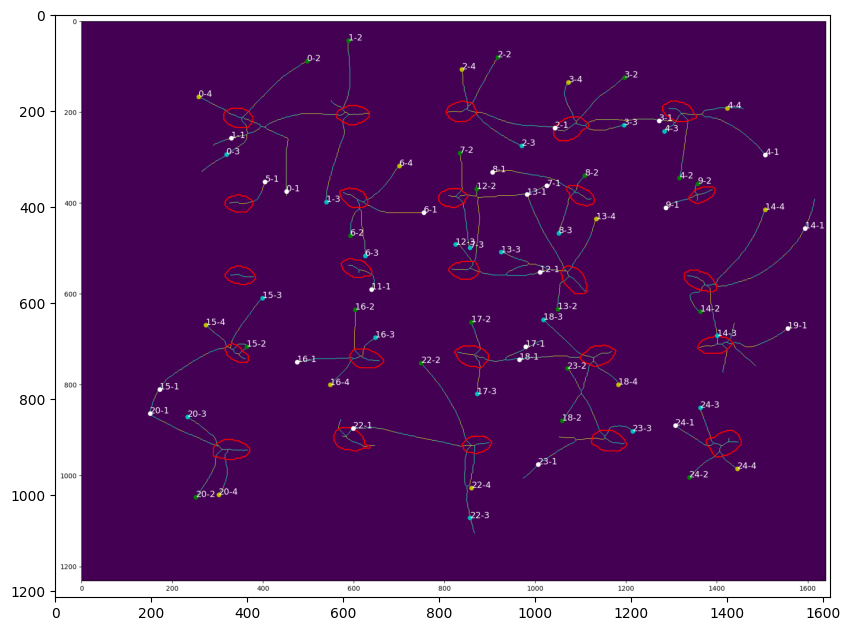

In [106]:
plt.figure(figsize=(10,10))
plt.imshow(final_root_tracking_img)

In [107]:
final_germinaton_img = io.imread('./example_G7/G7_20221029_2018.jpg')

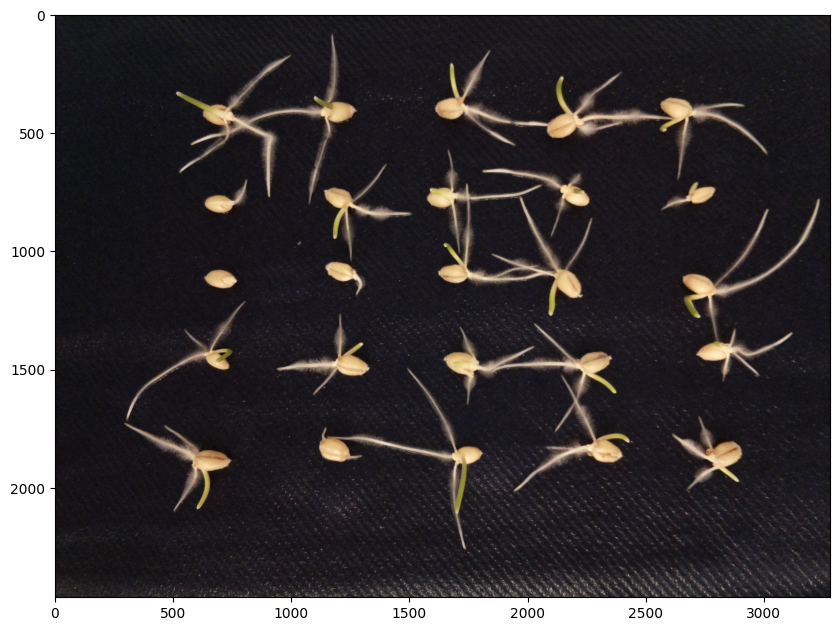

In [108]:
plt.figure(figsize=(10,10))
plt.imshow(final_germinaton_img)

In [109]:
seedling_remove_dict = {
    0:[4,],
    2:[4,],
    3:[4,],
    4:[3,],
    6:[2,],
    9:[2,],
    12:[3,],
    13:[2,],
    14:[2,],
    15:[2,],
    16:[3,],
    18:[4,],
    20:[4,],
    22:[4,],
    23:[3,],
    24:[4,],
}

### extract root data

In [114]:
root_1_data = []
root_2_data = []
root_3_data = []
for tmp_i in range(len(seed_class_list)):
    tmp_seed = seed_class_list[tmp_i]
    if tmp_seed.root_num == 0:
        root_1_data.append([])
        root_2_data.append([])
        root_3_data.append([])
    else:
        root_1_seed_id = None
        root_2_seed_id = None
        root_3_seed_id = None
        n = 0
        for root_id in seed_class_list[tmp_i].root_growth_rate_dict:
            if tmp_i in seedling_remove_dict:
                if root_id in seedling_remove_dict[tmp_i]:
                    continue
            if n == 0:
                root_1_seed_id = seed_class_list[tmp_i].root_growth_rate_dict[root_id]
            if n == 1:
                root_2_seed_id = seed_class_list[tmp_i].root_growth_rate_dict[root_id]
            if n == 2:
                root_3_seed_id = seed_class_list[tmp_i].root_growth_rate_dict[root_id]
            n += 1
        if root_1_seed_id is None:
            root_1_data.append([])
        else:
            root_1_data.append(root_1_seed_id)
        if root_2_seed_id is None:
            root_2_data.append([])
        else:
            root_2_data.append(root_2_seed_id)
        if root_3_seed_id is None:
            root_3_data.append([])
        else:
            root_3_data.append(root_3_seed_id)

### root 1 (primary root; radicle)

In [140]:
root_1_change_rate_df = pd.DataFrame(root_1_data)

In [143]:
root_1_change_rate_df *= 2 # because of resize
root_1_change_rate_df /= pixel2mm

In [144]:
root_1_change_rate_df

0    1    2    3    4    5    6    7         8         9         10  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.473088  1.926346  2.719547   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  2.266289  3.399433   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  2.266289   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  2.832861  1.813031   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
6   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  2.719547   
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.566572   
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  1.473088   
9   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
10  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
11  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  1.246459  2.266289   
13  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  2.946176   
14  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.019830  2.039660  3.059490   
15  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  1.926346  2.039660   
16  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
17  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
18  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.679887   
19  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  1.586402   
21  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
22  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  1.926346  3.172805   
23  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
24  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   

          11        12        13        14        15  
0   2.266289  1.699717  3.512748  2.946176  3.399433  
1   4.192635  3.852691  5.892351  2.492918  1.813031  
2   2.152975  2.266289  1.813031  4.985836  4.192635  
3   2.719547  1.133144  1.699717  2.492918  0.000000  
4   1.359773  2.152975  2.946176  3.399433  4.305949  
5   0.000000  0.000000  1.246459  1.359773  1.926346  
6   1.133144  1.926346  1.586402  2.266289  3.172805  
7   0.113314  1.813031  3.739377  4.645892  5.325779  
8   2.152975  2.039660  3.286119  2.946176  5.099150  
9   0.000000  0.793201  1.359773  0.793201  1.359773  
10       NaN       NaN       NaN       NaN       NaN  
11  0.000000  0.000000  0.000000  1.473088  1.586402  
12  2.946176  2.719547  3.399433  0.000000  0.000000  
13  2.379603  2.266289  2.492918  3.739377  5.665722  
14  3.399433  3.626062  3.966006  4.759207  0.000000  
15  2.492918  2.606232  3.852691  3.512748  0.000000  
16  1.359773  2.152975  1.699717  2.492918  3.172805  
17  0.000000  0.566572  1.926346  3.172805  0.000000  
18  2.606232  2.719547  2.719547  3.852691  0.000000  
19  1.473088  1.926346  3.059490  2.832861  4.192635  
20  2.719547  2.606232  2.379603  3.286119  3.399433  
21       NaN       NaN       NaN       NaN       NaN  
22  3.399433  3.966006  5.212465  2.492918  4.759207  
23  2.266289  1.019830  2.152975  3.172805  0.000000  
24  0.000000  0.000000  2.039660  1.926346  2.266289

In [145]:
root_1_change_rate_df.to_csv(os.path.join(out_dir, 'radicle_length_change_rate.csv'))

In [146]:
cumulative_root_1 = []
for tmp_i in range(len(root_1_change_rate_df)):
    row_data = root_1_change_rate_df.loc[tmp_i].values
    if row_data[0] is None:
        cumulative_root_1.append([])
        continue
    tmp_cumulative_seed = []
    for row_index in range(len(row_data)):
        tmp_cumulative_length = np.sum(row_data[:row_index+1])
        tmp_cumulative_seed.append(tmp_cumulative_length)
    cumulative_root_1.append(tmp_cumulative_seed)

In [147]:
cumulative_root_1_df = pd.DataFrame(cumulative_root_1)

In [148]:
cumulative_root_1_df

0    1    2    3    4    5    6    7         8         9         10  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.473088  3.399433  6.118980   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  2.266289  5.665722   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  2.266289   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  2.832861  4.645892   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
6   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  2.719547   
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.566572   
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  1.473088   
9   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
10  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
11  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  1.246459  3.512748   
13  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  2.946176   
14  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.019830  3.059490  6.118980   
15  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  1.926346  3.966006   
16  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
17  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
18  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.679887   
19  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  1.586402   
21  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
22  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  1.926346  5.099150   
23  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
24  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   

          11         12         13         14         15  
0   8.385269  10.084986  13.597734  16.543909  19.943343  
1   9.858357  13.711048  19.603399  22.096317  23.909348  
2   4.419263   6.685552   8.498584  13.484419  17.677054  
3   7.365439   8.498584  10.198300  12.691218  12.691218  
4   1.359773   3.512748   6.458924   9.858357  14.164306  
5   0.000000   0.000000   1.246459   2.606232   4.532578  
6   3.852691   5.779037   7.365439   9.631728  12.804533  
7   0.679887   2.492918   6.232295  10.878187  16.203966  
8   3.626062   5.665722   8.951841  11.898017  16.997167  
9   0.000000   0.793201   2.152975   2.946176   4.305949  
10       NaN        NaN        NaN        NaN        NaN  
11  0.000000   0.000000   0.000000   1.473088   3.059490  
12  6.458924   9.178470  12.577904  12.577904  12.577904  
13  5.325779   7.592068  10.084986  13.824363  19.490085  
14  9.518414  13.144476  17.110482  21.869688  21.869688  
15  6.458924   9.065156  12.917847  16.430595  16.430595  
16  1.359773   3.512748   5.212465   7.705382  10.878187  
17  0.000000   0.566572   2.492918   5.665722   5.665722  
18  3.286119   6.005666   8.725212  12.577904  12.577904  
19  1.473088   3.399433   6.458924   9.291785  13.484419  
20  4.305949   6.912181   9.291785  12.577904  15.977337  
21       NaN        NaN        NaN        NaN        NaN  
22  8.498584  12.464589  17.677054  20.169972  24.929178  
23  2.266289   3.286119   5.439093   8.611898   8.611898  
24  0.000000   0.000000   2.039660   3.966006   6.232295

In [149]:
cumulative_root_1_df.to_csv(os.path.join(out_dir, 'radicle_length.csv'))

### root 2

In [150]:
root_2_change_rate_df = pd.DataFrame(root_2_data)

In [151]:
root_2_change_rate_df *= 2 # because of resize
root_2_change_rate_df /= pixel2mm

In [152]:
root_2_change_rate_df

0    1    2    3    4    5    6    7    8         9         10        11  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.926346  1.699717  3.512748   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.699717  3.059490  2.379603   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  2.039660   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.492918  1.019830  0.793201   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  3.399433   
5   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
6   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  1.473088   
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.566572   
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.566572  1.133144   
9   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
10  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
11  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  3.059490  3.739377   
13  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  3.172805   
14  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.606232  2.719547  3.059490   
15  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  1.359773  2.266289   
16  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
17  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
18  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  2.719547   
19  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  2.266289   
21  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
22  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  3.626062  2.492918  2.719547   
23  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  2.719547   
24  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   

          12        13        14        15  
0   2.832861  2.152975  3.739377  3.172805  
1   2.152975  2.719547  2.719547  3.286119  
2   2.492918  2.379603  2.266289  2.379603  
3   0.226629  0.793201  2.152975  2.832861  
4   2.832861  2.152975  2.946176  3.966006  
5        NaN       NaN       NaN       NaN  
6   3.739377  2.606232  2.379603  2.379603  
7   2.039660  1.586402  2.492918  3.172805  
8   1.019830  0.226629  0.453258  0.453258  
9        NaN       NaN       NaN       NaN  
10       NaN       NaN       NaN       NaN  
11       NaN       NaN       NaN       NaN  
12  2.152975  3.172805  2.606232  4.192635  
13  4.759207  2.152975  0.000000  5.779037  
14  2.152975  1.586402  0.000000  0.000000  
15  1.813031  1.699717  2.039660  2.039660  
16  2.379603  2.606232  0.453258  2.832861  
17  0.000000  1.133144  2.266289  2.832861  
18  2.606232  3.286119  2.379603  3.852691  
19       NaN       NaN       NaN       NaN  
20  1.586402  1.813031  2.266289  2.606232  
21       NaN       NaN       NaN       NaN  
22  2.266289  2.946176  2.946176  3.172805  
23  4.079320  2.946176  1.926346  4.759207  
24  0.000000  2.152975  3.399433  2.039660

In [153]:
root_2_change_rate_df.to_csv(os.path.join(out_dir, 'root_2_length_change_rate.csv'))

In [154]:
cumulative_root_2 = []
for tmp_i in range(len(root_2_change_rate_df)):
    row_data = root_2_change_rate_df.loc[tmp_i].values
    if row_data[0] is None:
        cumulative_root_2.append([])
        continue
    tmp_cumulative_seed = []
    for row_index in range(len(row_data)):
        tmp_cumulative_length = np.sum(row_data[:row_index+1])
        tmp_cumulative_seed.append(tmp_cumulative_length)
    cumulative_root_2.append(tmp_cumulative_seed)

In [155]:
cumulative_root_2_df = pd.DataFrame(cumulative_root_2)

In [156]:
cumulative_root_2_df

0    1    2    3    4    5    6    7    8         9         10        11  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.926346  3.626062  7.138810   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.699717  4.759207  7.138810   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  2.039660   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.492918  3.512748  4.305949   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  3.399433   
5   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
6   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  1.473088   
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.566572   
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.566572  1.699717   
9   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
10  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
11  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  3.059490  6.798867   
13  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  3.172805   
14  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.606232  5.325779  8.385269   
15  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  1.359773  3.626062   
16  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
17  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
18  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  2.719547   
19  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  2.266289   
21  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
22  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  3.626062  6.118980  8.838527   
23  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  2.719547   
24  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   

           12         13         14         15  
0    9.971671  12.124646  15.864023  19.036827  
1    9.291785  12.011331  14.730878  18.016997  
2    4.532578   6.912181   9.178470  11.558074  
3    4.532578   5.325779   7.478754  10.311615  
4    6.232295   8.385269  11.331445  15.297450  
5         NaN        NaN        NaN        NaN  
6    5.212465   7.818697  10.198300  12.577904  
7    2.606232   4.192635   6.685552   9.858357  
8    2.719547   2.946176   3.399433   3.852691  
9         NaN        NaN        NaN        NaN  
10        NaN        NaN        NaN        NaN  
11        NaN        NaN        NaN        NaN  
12   8.951841  12.124646  14.730878  18.923513  
13   7.932011  10.084986  10.084986  15.864023  
14  10.538244  12.124646  12.124646  12.124646  
15   5.439093   7.138810   9.178470  11.218130  
16   2.379603   4.985836   5.439093   8.271955  
17   0.000000   1.133144   3.399433   6.232295  
18   5.325779   8.611898  10.991501  14.844193  
19        NaN        NaN        NaN        NaN  
20   3.852691   5.665722   7.932011  10.538244  
21        NaN        NaN        NaN        NaN  
22  11.104816  14.050992  16.997167  20.169972  
23   6.798867   9.745042  11.671388  16.430595  
24   0.000000   2.152975   5.552408   7.592068

In [157]:
cumulative_root_2_df.to_csv(os.path.join(out_dir, 'root_2_length.csv'))

### root 3

In [158]:
root_3_change_rate_df = pd.DataFrame(root_3_data)

In [159]:
root_3_change_rate_df *= 2 # because of resize
root_3_change_rate_df /= pixel2mm

In [160]:
root_3_change_rate_df

0    1    2    3    4    5    6    7    8         9         10        11  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.266289  1.359773  0.339943   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  3.626062  0.453258  2.266289   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  2.379603   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.566572  0.000000  0.453258   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
5   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
6   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  2.152975   
9   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
10  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
11  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
12  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
13  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
14  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  2.152975  1.926346   
15  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
16  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
17  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
18  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
19  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
21  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
22  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.606232  2.832861  2.266289   
23  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
24  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   

          12        13        14        15  
0   0.906516  2.152975  0.000000  0.000000  
1   3.172805  2.946176  4.532578  3.172805  
2   1.359773  2.152975  2.832861  3.966006  
3   1.586402  1.473088  2.039660  2.946176  
4   0.000000  1.926346  4.532578  0.000000  
5        NaN       NaN       NaN       NaN  
6   2.379603  1.926346  2.152975  3.512748  
7   2.492918  3.739377  3.172805  2.266289  
8   1.019830  1.473088  1.926346  2.946176  
9        NaN       NaN       NaN       NaN  
10       NaN       NaN       NaN       NaN  
11       NaN       NaN       NaN       NaN  
12       NaN       NaN       NaN       NaN  
13  2.492918  2.152975  3.286119  4.532578  
14  2.719547  2.946176  4.192635  4.872521  
15  1.699717  1.586402  1.246459  1.813031  
16  0.000000  2.719547  2.946176  2.606232  
17  0.000000  1.699717  2.832861  3.059490  
18  1.926346  2.379603  2.832861  2.946176  
19       NaN       NaN       NaN       NaN  
20  1.473088  2.039660  2.492918  2.719547  
21       NaN       NaN       NaN       NaN  
22  2.379603  3.286119  3.852691  0.000000  
23       NaN       NaN       NaN       NaN  
24  0.000000  2.946176  1.473088  2.719547

In [161]:
root_3_change_rate_df.to_csv(os.path.join(out_dir, 'root_3_length_change_rate.csv'))

In [162]:
cumulative_root_3 = []
for tmp_i in range(len(root_3_change_rate_df)):
    row_data = root_3_change_rate_df.loc[tmp_i].values
    if row_data[0] is None:
        cumulative_root_3.append([])
        continue
    tmp_cumulative_seed = []
    for row_index in range(len(row_data)):
        tmp_cumulative_length = np.sum(row_data[:row_index+1])
        tmp_cumulative_seed.append(tmp_cumulative_length)
    cumulative_root_3.append(tmp_cumulative_seed)

In [163]:
cumulative_root_3_df = pd.DataFrame(cumulative_root_3)

In [164]:
cumulative_root_3_df

0    1    2    3    4    5    6    7    8         9         10        11  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.266289  3.626062  3.966006   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  3.626062  4.079320  6.345609   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  2.379603   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.566572  0.566572  1.019830   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
5   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
6   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  2.152975   
9   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
10  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
11  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
12  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
13  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
14  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  2.152975  4.079320   
15  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
16  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
17  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
18  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
19  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
21  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
22  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  2.606232  5.439093  7.705382   
23  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN       NaN       NaN       NaN   
24  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   

           12         13         14         15  
0    4.872521   7.025496   7.025496   7.025496  
1    9.518414  12.464589  16.997167  20.169972  
2    3.739377   5.892351   8.725212  12.691218  
3    2.606232   4.079320   6.118980   9.065156  
4    0.000000   1.926346   6.458924   6.458924  
5         NaN        NaN        NaN        NaN  
6    2.379603   4.305949   6.458924   9.971671  
7    2.492918   6.232295   9.405099  11.671388  
8    3.172805   4.645892   6.572238   9.518414  
9         NaN        NaN        NaN        NaN  
10        NaN        NaN        NaN        NaN  
11        NaN        NaN        NaN        NaN  
12        NaN        NaN        NaN        NaN  
13   2.492918   4.645892   7.932011  12.464589  
14   6.798867   9.745042  13.937677  18.810198  
15   1.699717   3.286119   4.532578   6.345609  
16   0.000000   2.719547   5.665722   8.271955  
17   0.000000   1.699717   4.532578   7.592068  
18   1.926346   4.305949   7.138810  10.084986  
19        NaN        NaN        NaN        NaN  
20   1.473088   3.512748   6.005666   8.725212  
21        NaN        NaN        NaN        NaN  
22  10.084986  13.371105  17.223796  17.223796  
23        NaN        NaN        NaN        NaN  
24   0.000000   2.946176   4.419263   7.138810

In [165]:
cumulative_root_3_df.to_csv(os.path.join(out_dir, 'root_3_length.csv'))

## seedling related traits

### seedling emergence, chloroplast biogenesis, & the duration

In [170]:
seedling_data = {'seedling_emergence':[], 'seedling_trans':[]}
for tmp_i in range(len(seed_class_list)):
    tmp_seed = seed_class_list[tmp_i]
    seedling_data['seedling_emergence'].append(tmp_seed.seedling_emergence)
    seedling_data['seedling_trans'].append(tmp_seed.seedling_trans)
seedling_data_df = pd.DataFrame(seedling_data)

In [176]:
seedling_data_df

seedling_emergence seedling_trans
0                   9             10
1                   8             12
2                  12             12
3                  11               
4                  11             13
5                                   
6                  10             12
7                  10             14
8                   9             12
9                  14             14
10                                  
11                                  
12                 10             12
13                 10             11
14                  7              8
15                  9             11
16                 13               
17                 13             14
18                 11             13
19                 12             12
20                 11             12
21                                  
22                  9             11
23                 12               
24                 14             15

In [183]:
tmp_duration = []
for i in range(len(seedling_data_df)):
    row_data = seedling_data_df.loc[i].values
    if row_data[0] == "" or row_data[1] == "":
        tmp_duration.append("")
    else:
        tmp_duration.append(row_data[1] - row_data[0])

In [185]:
seedling_data_df['duration'] = tmp_duration

In [187]:
seedling_data_df

seedling_emergence seedling_trans duration
0                   9             10        1
1                   8             12        4
2                  12             12        0
3                  11                        
4                  11             13        2
5                                            
6                  10             12        2
7                  10             14        4
8                   9             12        3
9                  14             14        0
10                                           
11                                           
12                 10             12        2
13                 10             11        1
14                  7              8        1
15                  9             11        2
16                 13                        
17                 13             14        1
18                 11             13        2
19                 12             12        0
20                 11             12        1
21                                           
22                  9             11        2
23                 12                        
24                 14             15        1

In [188]:
seedling_data_df.to_csv(os.path.join(out_dir, 'seedling_timepoint_&_duration.csv'))

### seedling length

In [189]:
seedling_length = []
for tmp_i in range(len(seed_class_list)):
    seedling_length.append(seed_class_list[tmp_i].seedling_len)
seedling_length_df = pd.DataFrame(seedling_length)

In [190]:
seedling_length_df *= 2
seedling_length_df /= pixel2mm

In [191]:
seedling_length_df

0    1    2    3    4    5    6    7         8         9         10  \
0   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  2.152975  4.532578   
1   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.019830  2.152975  1.926346   
2   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
3   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
4   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
5   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
6   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.226629   
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  1.359773  2.039660   
9   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
11  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
12  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  1.019830   
13  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
14  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.359773  2.039660  3.626062   
15  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
16  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
17  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
18  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
19  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
20  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
21  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
22  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.453258  1.246459   
23  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   
24  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000   

          11        12        13        14         15  
0   6.005666  7.818697  8.158640  8.951841  10.991501  
1   2.492918  1.699717  0.566572  1.926346   3.739377  
2   0.000000  1.473088  3.059490  0.000000   0.000000  
3   2.266289  0.000000  0.000000  0.000000   0.000000  
4   0.000000  0.000000  3.739377  0.000000   0.000000  
5   0.000000  0.000000  0.000000  0.000000   0.000000  
6   0.000000  2.606232  0.000000  0.000000   0.000000  
7   0.793201  2.492918  2.832861  3.626062   4.079320  
8   3.059490  2.946176  2.266289  1.133144   2.606232  
9   0.000000  0.000000  0.000000  1.586402   2.606232  
10  0.000000  0.000000  0.000000  0.000000   0.000000  
11  0.000000  0.000000  0.000000  0.000000   0.000000  
12  0.000000  2.492918  3.739377  4.192635   4.759207  
13  1.586402  0.000000  4.192635  5.665722   7.025496  
14  0.000000  0.000000  7.592068  0.000000   0.000000  
15  2.606232  3.739377  3.512748  5.212465   4.872521  
16  0.000000  0.000000  0.000000  0.000000   0.000000  
17  0.000000  0.000000  1.019830  2.606232   2.946176  
18  0.226629  0.000000  2.492918  4.192635   6.118980  
19  0.000000  1.586402  2.606232  2.719547   2.832861  
20  0.000000  1.359773  3.172805  5.665722   8.611898  
21  0.000000  0.000000  0.000000  0.000000   0.000000  
22  2.266289  4.192635  7.025496  9.518414  13.257790  
23  0.000000  1.246459  0.000000  0.000000   0.000000  
24  0.000000  0.000000  0.000000  1.359773   3.852691

In [192]:
seedling_length_df.to_csv(os.path.join(out_dir, 'seedling_length.csv'))

# exhibition of seed-level root tracking results

In [195]:
import matplotlib.cm as cm

In [193]:
exhibition_mask = np.zeros(seedling_mask.shape)

In [194]:
for tmp_i in range(len(seed_class_list)):
    for line_num in seed_class_list[tmp_i].reconstruction_ske:
        if seedling_remove_dict.get(tmp_i):
            if line_num in seedling_remove_dict[tmp_i]:
                continue
        rr = seed_class_list[tmp_i].reconstruction_ske[line_num]['rr']
        cc = seed_class_list[tmp_i].reconstruction_ske[line_num]['cc']
        for n in range(len(rr)):
            if rr[n] == ['']:
                continue
            for point_num in range(len(rr[n])):
                tmp_rr = rr[n][point_num]
                tmp_cc = cc[n][point_num]
                exhibition_mask[tmp_rr, tmp_cc] = (n + 1) * 5

C:\Users\hp\AppData\Local\Temp\ipykernel_18144\220403307.py:9: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if rr[n] == ['']:


In [196]:
jet = cm.get_cmap('jet')

C:\Users\hp\AppData\Local\Temp\ipykernel_18144\1536282389.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap('jet')


In [197]:
norm_data = (exhibition_mask - np.min(exhibition_mask))/(100-np.min(exhibition_mask))

In [199]:
colors = jet(norm_data)

(-0.5, 1639.5, 1231.5, -0.5)

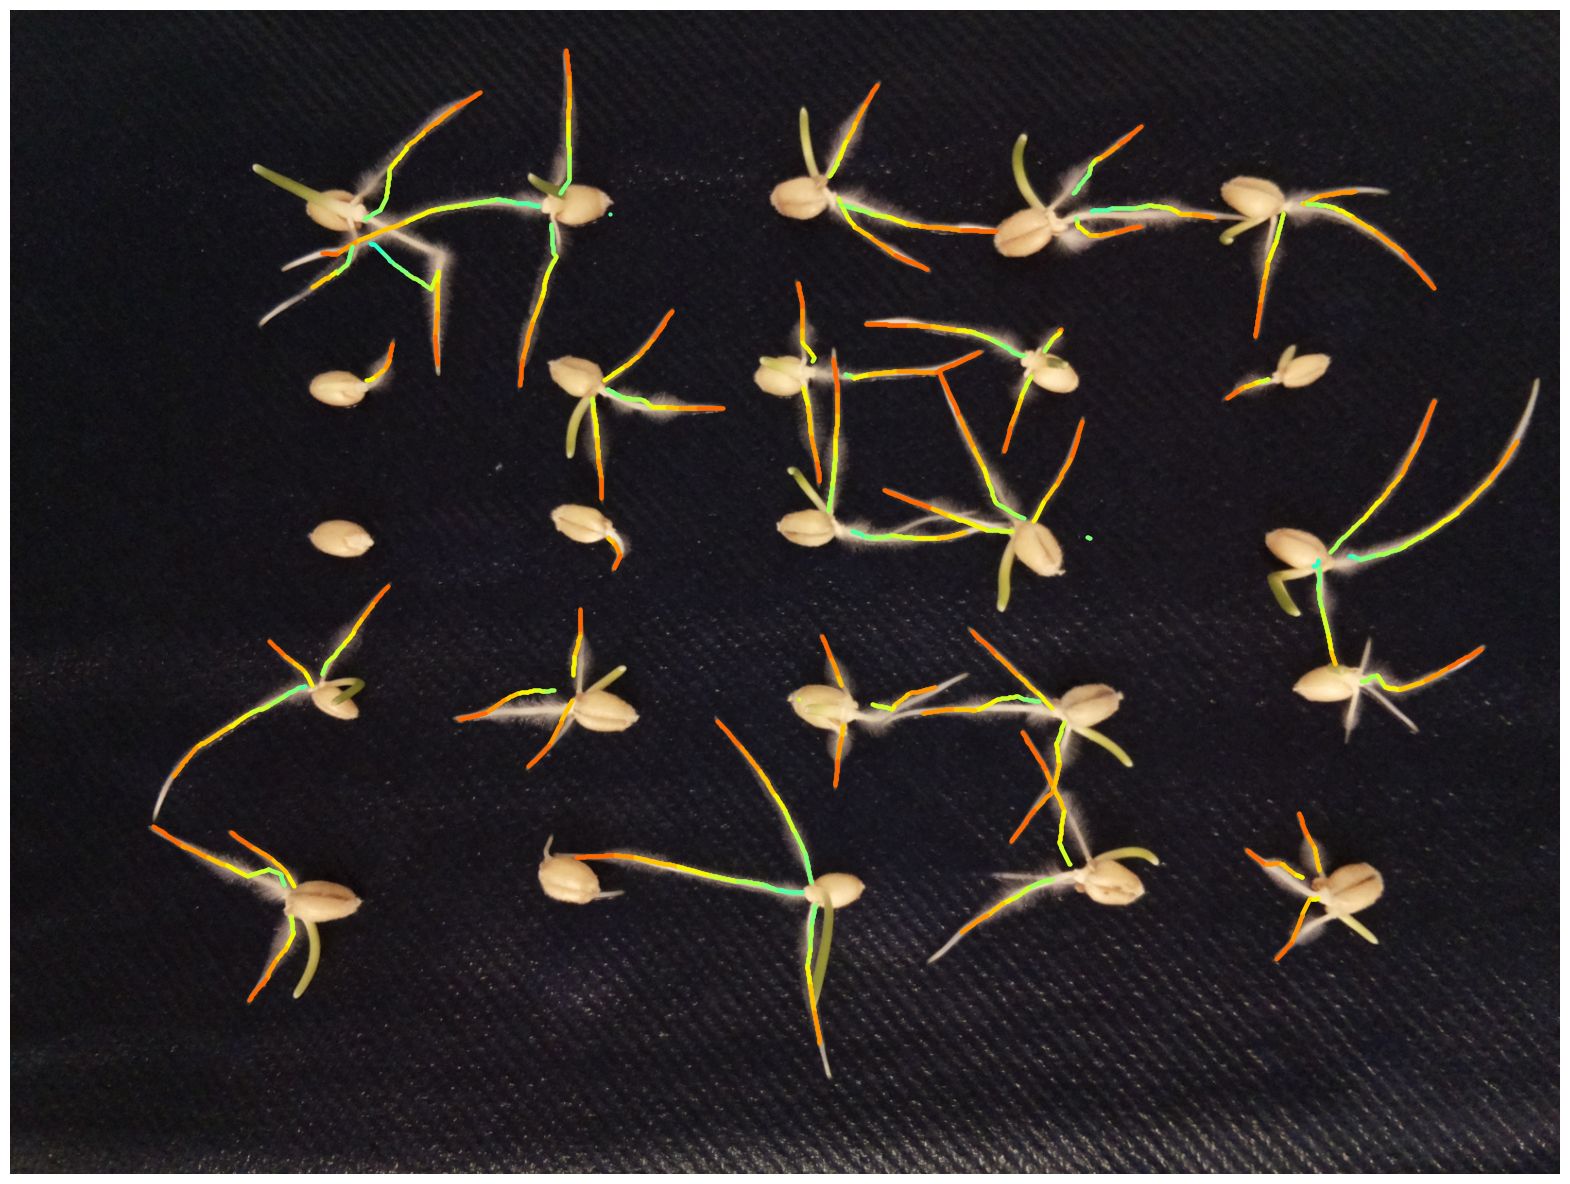

In [200]:
plt.figure(figsize=(20,20))
plt.imshow(image_origion)

for tmp_rr, tmp_cc in np.argwhere(exhibition_mask > 0):
    tmp_jet_value = colors[tmp_rr,tmp_cc]
    tmp_color = (tmp_jet_value[0], tmp_jet_value[1], tmp_jet_value[2])
    plt.plot(tmp_cc, tmp_rr, color = tmp_color, marker = 'o',markersize = '2')

plt.axis('off')